In [1]:
import sys
#sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock, compute_comethylation
%autoreload 1
import get_data, analysis, utils, plotting, compute_comethylation, methyl_mut_burden, mutation_features, methylation_pred

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr
from rich.progress import track
import statsmodels.formula.api as smf
import matplotlib.ticker as ticker
import colorcet as cc
from scipy.stats import spearmanr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")

In [3]:
out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output"
dependency_f_dir = "./dependency_files"
data_dir = "./data"
corr_dir = '/cellar/users/zkoch/methylation_and_mutation/dependency_files/chr_dset_corrs'
#methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/dropped3SD_qnormed_methylation'
methylation_dir = '/cellar/users/zkoch/methylation_and_mutation/data/processed_methylation'
icgc_dir = "/cellar/users/zkoch/methylation_and_mutation/data/icgc"

# TCGA

### Get data

In [4]:
illumina_cpg_locs_df, all_mut_df, all_methyl_df, all_methyl_df_t, all_meta_df, dataset_names_list = get_data.main(
    illum_cpg_locs_fn = os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"),
    out_dir = out_dir,
    methyl_dir = methylation_dir,
    mut_fn = os.path.join(data_dir, "PANCAN_mut.tsv.gz"),
    meta_fn = os.path.join(data_dir, "PANCAN_meta.tsv"))

Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


In [5]:
# read in other already computed files
mut_in_measured_cpg_w_methyl_age_df = pd.read_parquet(os.path.join(dependency_f_dir, "mut_in_measured_cpg_w_methyl_age_df_5year.parquet"))
all_mut_w_age_df, all_methyl_age_df_t = utils.add_ages_to_mut_and_methyl(all_mut_df, all_meta_df, all_methyl_df_t)

# ICGC

### Get data

In [80]:
icgc_mut_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_mut_df.parquet")
icgc_meta_df = pd.read_parquet("/cellar/users/zkoch/methylation_and_mutation/data/icgc/for_matrixQTL/icgc_meta_df.parquet")
illumina_cpg_locs_df = get_data.get_illum_locs(os.path.join(dependency_f_dir, "illumina_cpg_450k_locations.csv"))
icgc_methyl_dd = dd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/icgc/methyl_dir')
icgc_methyl_df = icgc_methyl_dd.compute()
icgc_methyl_df_t = icgc_methyl_df.T
shared_samples = set(icgc_methyl_df_t.index) & set(icgc_mut_df['sample'].unique()) & set(icgc_meta_df['sample'].unique())
icgc_methyl_df_t = icgc_methyl_df_t.loc[shared_samples]
icgc_methyl_df_t.dropna(how = 'any', axis=1, inplace=True)
icgc_mi_df = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/011723_output/icgc_mi.parquet')
icgc_mi_df.sort_values(by='mutual_info', ascending=False, inplace=True)

In [30]:
icgc_meta_df['dataset'].value_counts()

PRAD-CA    241
PACA-AU    167
OV-AU       93
PBCA-DE     74
CLLE-ES     55
PAEN-AU     22
UTCA-FR     17
PRAD-UK      3
Name: dataset, dtype: int64

In [81]:
# rename columns 
icgc_mut_df.rename(columns={'chromosome':'chr', 'sample': 'case_submitter_id', 'chromosome_start':'start', 'MAF': 'DNA_VAF'}, inplace=True)
icgc_meta_df.rename(columns={'sample': 'case_submitter_id'}, inplace=True)
# merge with mut
icgc_mut_w_age_df = icgc_mut_df.merge(icgc_meta_df, on='case_submitter_id', how='left')
# and methyl dfs
icgc_meta_df_to_merge = icgc_meta_df[['case_submitter_id', 'age_at_index', 'dataset', 'gender']]
icgc_meta_df_to_merge.set_index('case_submitter_id', inplace=True)
# make gender column uppercase
icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()
icgc_methyl_age_df_t = icgc_methyl_df_t.merge(icgc_meta_df_to_merge, left_index=True, right_index=True, how='left')

/tmp/ipykernel_1597874/2635062645.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  icgc_meta_df_to_merge['gender'] = icgc_meta_df_to_merge['gender'].str.upper()


# TODO

In [ ]:
"""
1) Profile what the slowest part of creating feature matrices is and/or parallelize (either through bash jobs or python)
2) Wrap the whole thing in a 5 fold cross validation, so changing the training and testing samples each time
2) for some reason the training samples are not getting subset correctly
3) Get the ICGC data to work
"""

# Epi-clock modelling

### How many CpGs are necessary?

In [304]:
# choose which CpGs to generate features for
corrs = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
corrs.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
corrs = corrs.to_frame()
corrs.columns = ['corr']

In [303]:
corrs.to_parquet('/cellar/users/zkoch/methylation_and_mutation/dependency_files/cpg_age_corrs/SKCM_cpg_age_corrs.parquet')

,corr
cg13212963,-0.086806
cg26582803,0.050500
cg14150907,0.097212
cg08424876,-0.041250
cg09636313,-0.044279
...,...
cg11697588,0.065073
cg05375744,0.008874
cg05502283,0.063071
cg12404990,-0.087943


In [224]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = 0,
    )
cpg_pred_priority_corr = mut_feat.choose_cpgs_to_train(metric_df = corrs, bin_size = 20000, sort_by=['corr', 'mean_count'], mean = True)
cpg_pred_priority_mi = mut_feat.choose_cpgs_to_train(metric_df = mi_df, bin_size = 20000, sort_by=['mutual_info', 'mean_count'], mean = True)

In [229]:
cpg_pred_priority_corr['abs_corr'] = cpg_pred_priority_corr['corr'].abs()
cpg_pred_priority_corr.sort_values(by='abs_corr', ascending=False, inplace=True)
corr_chosen_cpgs_lists = []
for i in [1, 10, 100, 1000, 10000]:
    corr_chosen_cpgs_lists.append(cpg_pred_priority_corr.iloc[:i]['#id'].tolist())

In [ ]:
r2s, maes = [], []
for chosen_cpgs in corr_chosen_cpgs_lists:
    model = sklearn.linear_model.ElasticNetCV(max_iter=10000, cv=3, n_jobs=-1)

    X = all_methyl_age_df_t.loc[mut_feat.train_samples, chosen_cpgs]
    y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
    # fit actual methylation values of training samples
    model.fit(X, y)

    preds_age = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, chosen_cpgs])
    actual_age = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
    r2s.append(np.corrcoef(preds_age, actual_age)[0,1]**2)
    maes.append(sklearn.metrics.mean_absolute_error(preds_age, actual_age))
    print("done", flush=True)
print(r2s)

In [231]:
# same for mutual information
cpg_pred_priority_mi.sort_values(by='mutual_info', ascending=False, inplace=True)
mi_chosen_cpgs_lists = []
for i in [1, 10, 100, 1000, 10000]:
    mi_chosen_cpgs_lists.append(cpg_pred_priority_mi.iloc[:i]['#id'].tolist())

In [232]:
r2s, maes = [], []
for chosen_cpgs in mi_chosen_cpgs_lists:
    model = sklearn.linear_model.ElasticNetCV(max_iter=10000, cv=3, n_jobs=-1)

    X = all_methyl_age_df_t.loc[mut_feat.train_samples, chosen_cpgs]
    y = all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
    # fit actual methylation values of training samples
    model.fit(X, y)

    preds_age = model.predict(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, chosen_cpgs])
    actual_age = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
    r2s.append(np.corrcoef(preds_age, actual_age)[0,1]**2)
    maes.append(sklearn.metrics.mean_absolute_error(preds_age, actual_age))
    print("done", flush=True)
print(r2s)

done
done
done
done
done
[0.022203061831685408, 0.09932204938003975, 0.0857762818505133, 0.1551099480720156, 0.23800466146008298]


In [247]:
r2s

[0.022203061831685408,
 0.09932204938003975,
 0.0857762818505133,
 0.1551099480720156,
 0.23800466146008298]

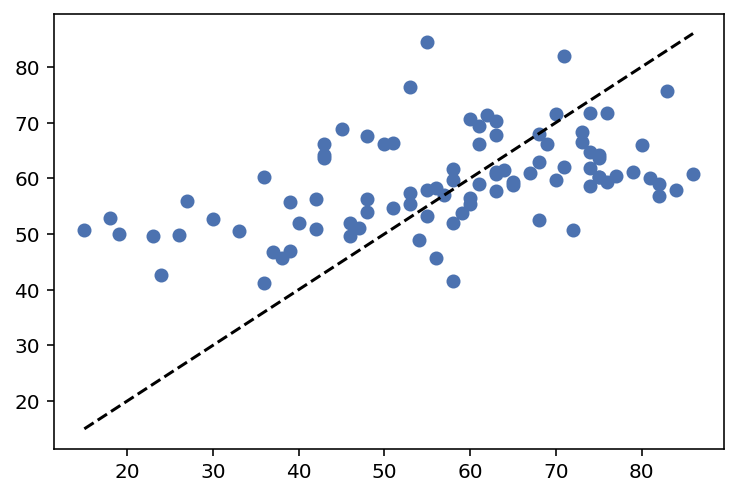

In [235]:
plt.scatter(actual_age, preds_age)
plt.plot([min(actual_age),max(actual_age)], [min(actual_age),max(actual_age)], c='black', linestyle='--')


# Mutation features

#### Development

In [6]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs_for_mutClock.parquet')

In [110]:
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = 1, matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts"
    )

In [141]:
mut_feat.create_all_feat_mats(
        cpg_ids = ['cg08318076'], 
        aggregate = 'Both',
        num_correl_sites = 500,
        num_correl_ext_sites = 500,
        max_meqtl_sites = 100,
        nearby_window_size = 50000,
        num_db_sites = 26000)

Finished 0 of 1


In [111]:
# calculate age corrs for choosing cpgs
corrs = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
corrs.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
corrs = corrs.to_frame()
corrs.columns = ['corr']
corrs['corr'] = corrs['corr'].abs()

meqtl_counts = godmc_meqtls['cpg'].value_counts().to_frame()


In [117]:
cpg_pred_priority = mut_feat.choose_cpgs_to_train(metric_df = corrs, bin_size = 20000, sort_by=['corr', 'count'], mean = True)

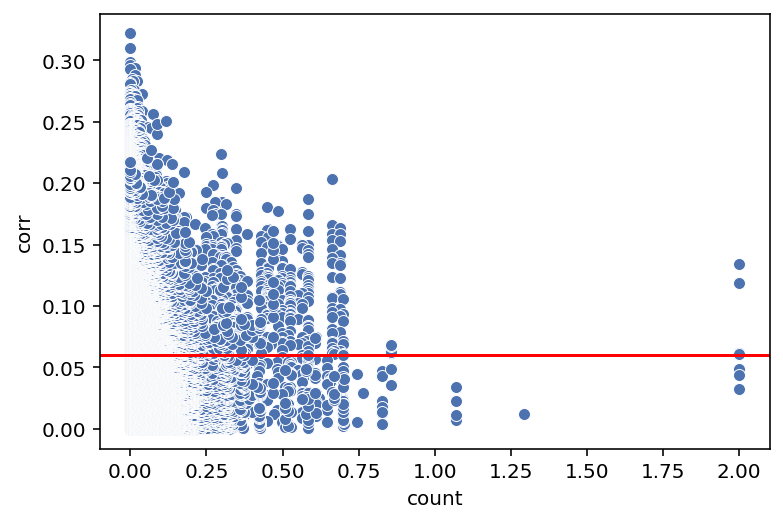

In [115]:
cpg_pred_priority['corr'] = cpg_pred_priority['corr'].abs()
sns.scatterplot(y='corr', x='count', data=cpg_pred_priority)
# draw lines y = .1 and y = -.1
plt.axhline(y=.06, color='r', linestyle='-')
# draw line x = .2

In [450]:
chosen_cpgs = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), '#id']
mut_feat.create_all_feat_mats(
    cpg_ids = ['cg20154947', 'cg05320382', 'cg26763284', 'cg08718031', 'cg23186643'], aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=1000,
    nearby_window_size=25000, num_db_sites = 5000
    )
mut_feat_store_fn = mut_feat.save_mutation_features()

cg20154947
Finished 0 of 5
cg05320382
cg26763284
cg08718031
cg23186643
Saved mutation features to
/cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/TCGA_SKCM_5000correl_100correlExt_1000meqtl_25000nearby_Bothagg_5numCpGs_startTopCpGs_crossValNum/TCGA_SKCM_5000correl_100correlExt_1000meqtl_25000nearby_Bothagg_5numCpGs_startTopCpGs_crossValNum.features.pkl


In [351]:
methyl_pred.perf_df['age_corr'] = methyl_pred.pred_df.corrwith(mut_feat.all_methyl_age_df_t.loc[methyl_pred.test_samples, 'age_at_index'])
methyl_pred.perf_df['count'] = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), 'count'].to_list()
methyl_pred.perf_df['real_age_corr'] = cpg_pred_priority.loc[(np.abs(cpg_pred_priority['corr']) > .14) & (cpg_pred_priority['count'] > 0.08), 'corr'].to_list()

0.0128930910165799
0.010259910775147187
0.000506552060642544
0.031676478429084776


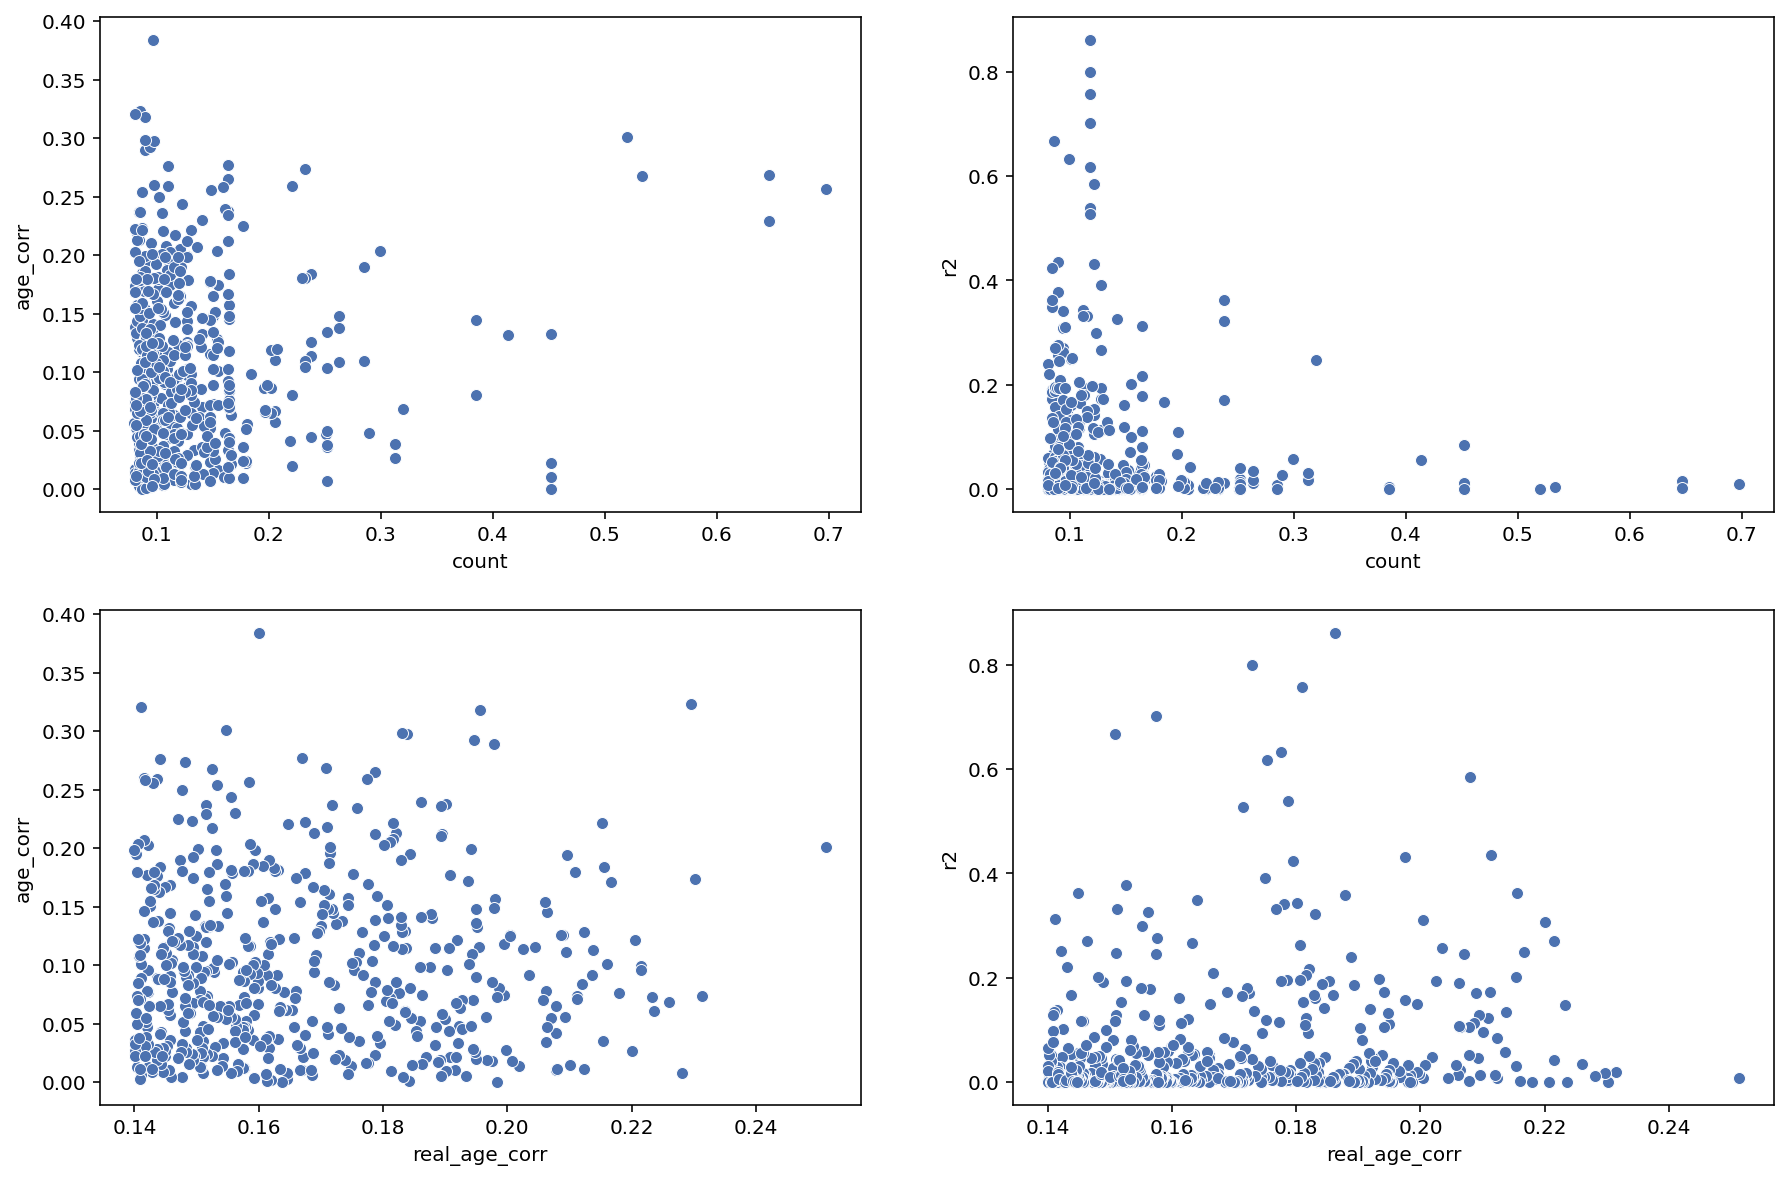

In [358]:
fig, axes = plt.subplots(2,2, figsize=(15,10))
axes = axes.flatten()
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='count', y='age_corr', ax = axes[0])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='count', y='r2', ax = axes[1])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='real_age_corr', y='age_corr', ax = axes[2])
sns.scatterplot(data = np.abs(methyl_pred.perf_df), x='real_age_corr', y='r2', ax = axes[3])
# print r2 beteween each of these vlaues
print(np.corrcoef(np.abs(methyl_pred.perf_df)['count'], np.abs(methyl_pred.perf_df)['age_corr'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['count'], np.abs(methyl_pred.perf_df)['r2'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['real_age_corr'],np.abs(methyl_pred.perf_df)['age_corr'])[0,1]**2)
print(np.corrcoef(np.abs(methyl_pred.perf_df)['real_age_corr'], np.abs(methyl_pred.perf_df)['r2'])[0,1]**2)


#### Read in predicted methylation

In [6]:
godmc_meqtls = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/data/meQTL/goDMC_meQTL/goDMC_meQTLs_for_mutClock.parquet')

Text(0.05, 0.95, 'r2 = 0.001')

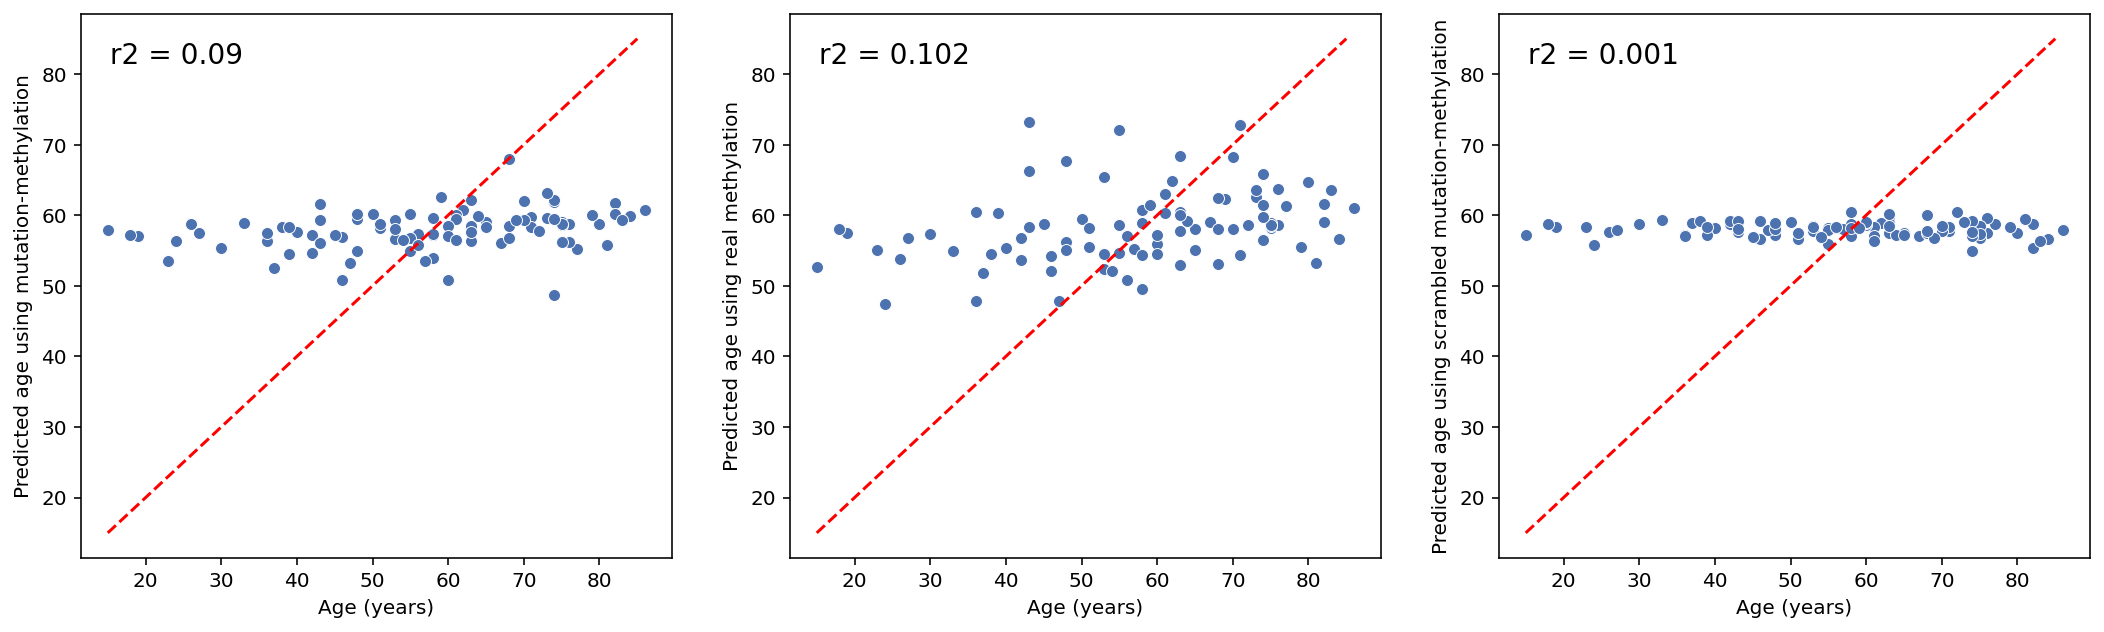

In [149]:
cross_val = 0
# create feature object to get train and test sample info from
mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, meqtl_db = godmc_meqtls, out_dir = out_dir, consortium = 'TCGA', dataset = 'SKCM',
    cross_val_num = cross_val, matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/data/matrixQtl_data/muts", use_old = True
    )
# read in results of methylation for fold 0
pred_methyl_fns = glob.glob(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*{cross_val}crossValNum/methyl_predictions_*Falsescramble.parquet")
pred_perf_fns = glob.glob(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*{cross_val}crossValNum/prediction_performance_*Falsescramble.parquet")
scrambled_pred_methyl_fns = glob.glob(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*{cross_val}crossValNum/methyl_predictions_*Truescramble.parquet")

mut_clock = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = pred_methyl_fns,
            predicted_perf_fns = pred_perf_fns,
            scrambled_predicted_methyl_fns = scrambled_pred_methyl_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output",
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = ''
            )
mut_clock._populate_performance()

# best predicted cpgs are the top 5000 cpgs whose correlation with real values were highest in training samples
best_predicted_cpgs = mut_clock.performance_df['training_pred_real_mf_r'].nlargest(100000).index
real_testing_X = mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, best_predicted_cpgs]
predicted_testing_X = mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, best_predicted_cpgs]
scrambled_predicted_testing_X = mut_clock.scrambled_predicted_methyl_df.loc[mut_feat.test_samples, best_predicted_cpgs]
y = mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']

y_train = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']
real_training_X = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples, best_predicted_cpgs]
# train a clock on real methylation data
real_testing_model = mut_clock.train_epi_clock(real_training_X, y_train)
# using this to predict age with predicted methylation values
predicted_methyl_pred_ages = real_testing_model.predict(predicted_testing_X)
# predict scrambnled methylation values
scrambled_predicted_methyl_pred_ages = real_testing_model.predict(scrambled_predicted_testing_X)
# use this to predict age with real methylation values (positive control)
real_methyl_pred_ages = real_testing_model.predict(real_testing_X)

to_plot_df = pd.DataFrame({'Age (years)': y, 'Predicted age using mutation-methylation': predicted_methyl_pred_ages, 'Predicted age using scrambled mutation-methylation': scrambled_predicted_methyl_pred_ages, 'Predicted age using real methylation': real_methyl_pred_ages})

# keep y labels even though sharing y axis
fig, axes = plt.subplots(1, 3, figsize=(18,5), sharex=True, sharey=True)
axes[1].yaxis.set_tick_params(labelbottom=True)
axes[2].yaxis.set_tick_params(labelbottom=True)
# report results with a scatterplot and correlation
sns.scatterplot(data=to_plot_df, x = 'Age (years)', y = 'Predicted age using mutation-methylation', ax = axes[0])
axes[0].plot([15,85], [15,85], ls="--", color = 'red')
axes[0].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(to_plot_df['Age (years)'], to_plot_df['Predicted age using mutation-methylation'])[0,1]**2, 3)), transform=axes[0].transAxes, fontsize=14, verticalalignment='top', c= 'black')

# positive control
sns.scatterplot(data=to_plot_df, x = 'Age (years)', y = 'Predicted age using real methylation', ax = axes[1])
axes[1].plot([15,85], [15,85], ls="--", color = 'red')
axes[1].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(to_plot_df['Age (years)'], to_plot_df['Predicted age using real methylation'])[0,1]**2, 3)), transform=axes[1].transAxes, fontsize=14, verticalalignment='top', c= 'black')

# negative control
sns.scatterplot(data=to_plot_df, x = 'Age (years)', y = 'Predicted age using scrambled mutation-methylation', ax = axes[2])
axes[2].plot([15,85], [15,85], ls="--", color = 'red')
axes[2].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(to_plot_df['Age (years)'], to_plot_df['Predicted age using scrambled mutation-methylation'])[0,1]**2, 3)), transform=axes[2].transAxes, fontsize=14, verticalalignment='top', c= 'black')


In [100]:
mut_clock._populate_performance()


Text(0, 0.5, 'R2 predicted methylation with actual methylation')

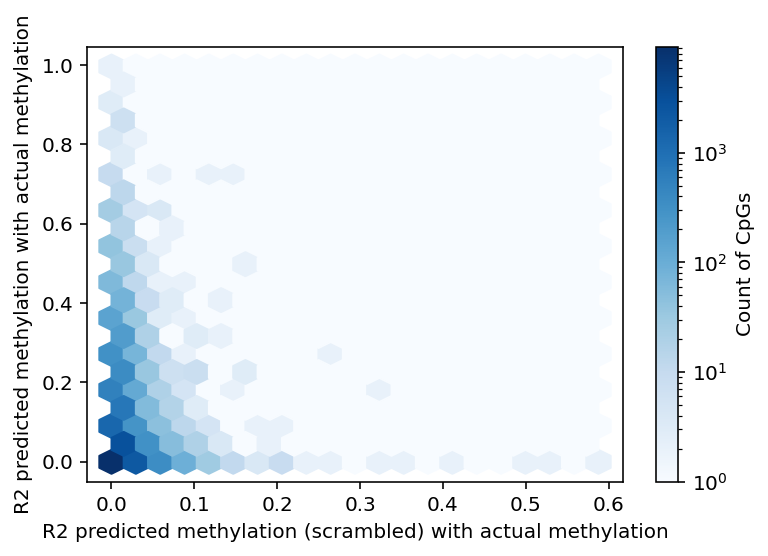

In [68]:
plt.hexbin(mut_clock.performance_df['testing_scrambled_real_mf_r']**2, mut_clock.performance_df['testing_methyl_r']**2, gridsize=20, cmap='Blues', bins = 'log')
# label color bar
plt.colorbar(label='Count of CpGs')
plt.xlabel("R2 predicted methylation (scrambled) with actual methylation")
plt.ylabel("R2 predicted methylation with actual methylation")

In [147]:
mut_clock.performance_df.sort_values(by = ['testing_real_mf_age_r'], ascending = [ False]).head(15)

,testing_methyl_r,testing_methyl_mae,training_real_mf_age_r,training_pred_mf_age_r,training_pred_real_mf_r,testing_scrambled_real_mf_r,testing_pred_mf_age_r,testing_real_mf_age_r
cg15243034,0.130495,0.124907,0.253587,0.190002,0.777220,-0.081595,0.108390,0.356477
cg10638657,0.613388,0.180452,0.179887,0.200241,0.965777,-0.079739,0.302302,0.349606
cg14359052,0.130744,0.239172,0.164820,0.238881,0.817410,-0.077550,0.221521,0.343853
cg21024916,0.738188,0.116869,0.196319,0.201955,0.989757,-0.054302,0.248079,0.337311
cg09136052,0.268745,0.171166,0.150018,0.172205,0.903727,-0.114738,0.220156,0.334823
cg25091056,0.681194,0.164867,0.195012,0.203804,0.977248,-0.095708,0.289712,0.330895
cg08887153,0.273423,0.224745,0.200916,0.234476,0.903990,0.019725,0.211205,0.328603
cg14181271,0.026381,0.142566,0.176834,0.041455,0.560686,0.044181,0.147951,0.328003
cg01073463,0.037403,0.197866,0.167644,0.191884,0.807841,0.059154,0.105089,0.325566
cg14588411,0.175475,0.172519,0.158615,0.196802,0.800929,-0.001080,0.252959,0.325326


Text(0, 0.5, 'Methylation fraction')

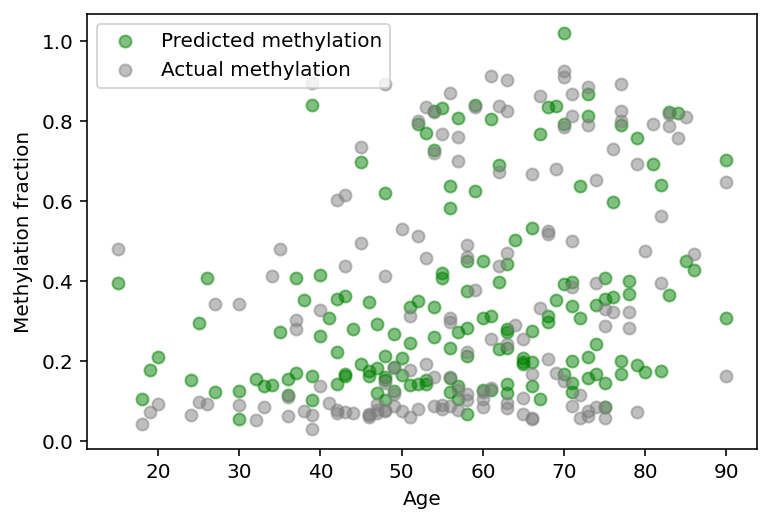

In [148]:
cpg = 'cg10638657'
plt.scatter(mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'], mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, cpg], label = 'Predicted methylation', c= 'green', alpha = 0.5)
plt.scatter(mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'], mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, cpg], label = 'Actual methylation', c = 'grey', alpha = 0.5)
plt.legend()
plt.xlabel("Age")
plt.ylabel("Methylation fraction")

Text(0, 0.5, 'R2 predicted methylation with actual methylation')

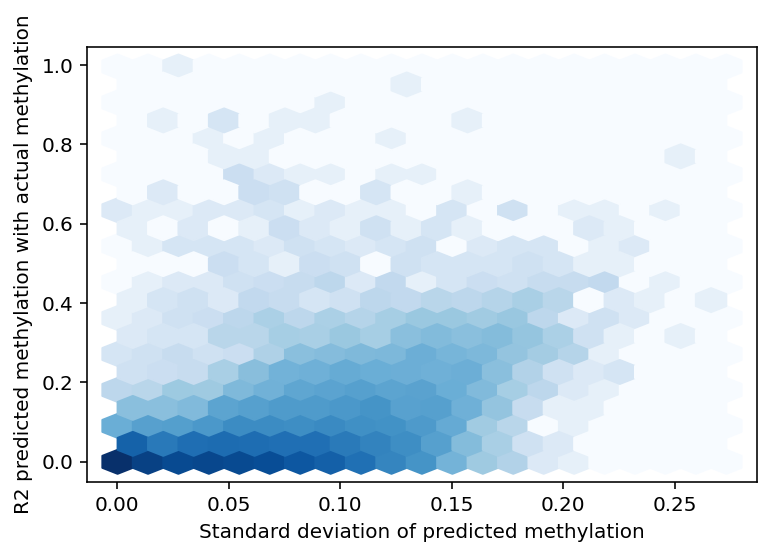

In [67]:
mut_clock.performance_df['stdev_testing_predicted_methyl'] = mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, :].std(axis=0)
plt.hexbin(mut_clock.performance_df['stdev_testing_predicted_methyl'], mut_clock.performance_df['testing_methyl_r']**2, gridsize=20, cmap='Blues', bins = 'log')
plt.xlabel("Standard deviation of predicted methylation")
plt.ylabel("R2 predicted methylation with actual methylation")

Text(0.05, 0.95, 'r2 = 0.02')

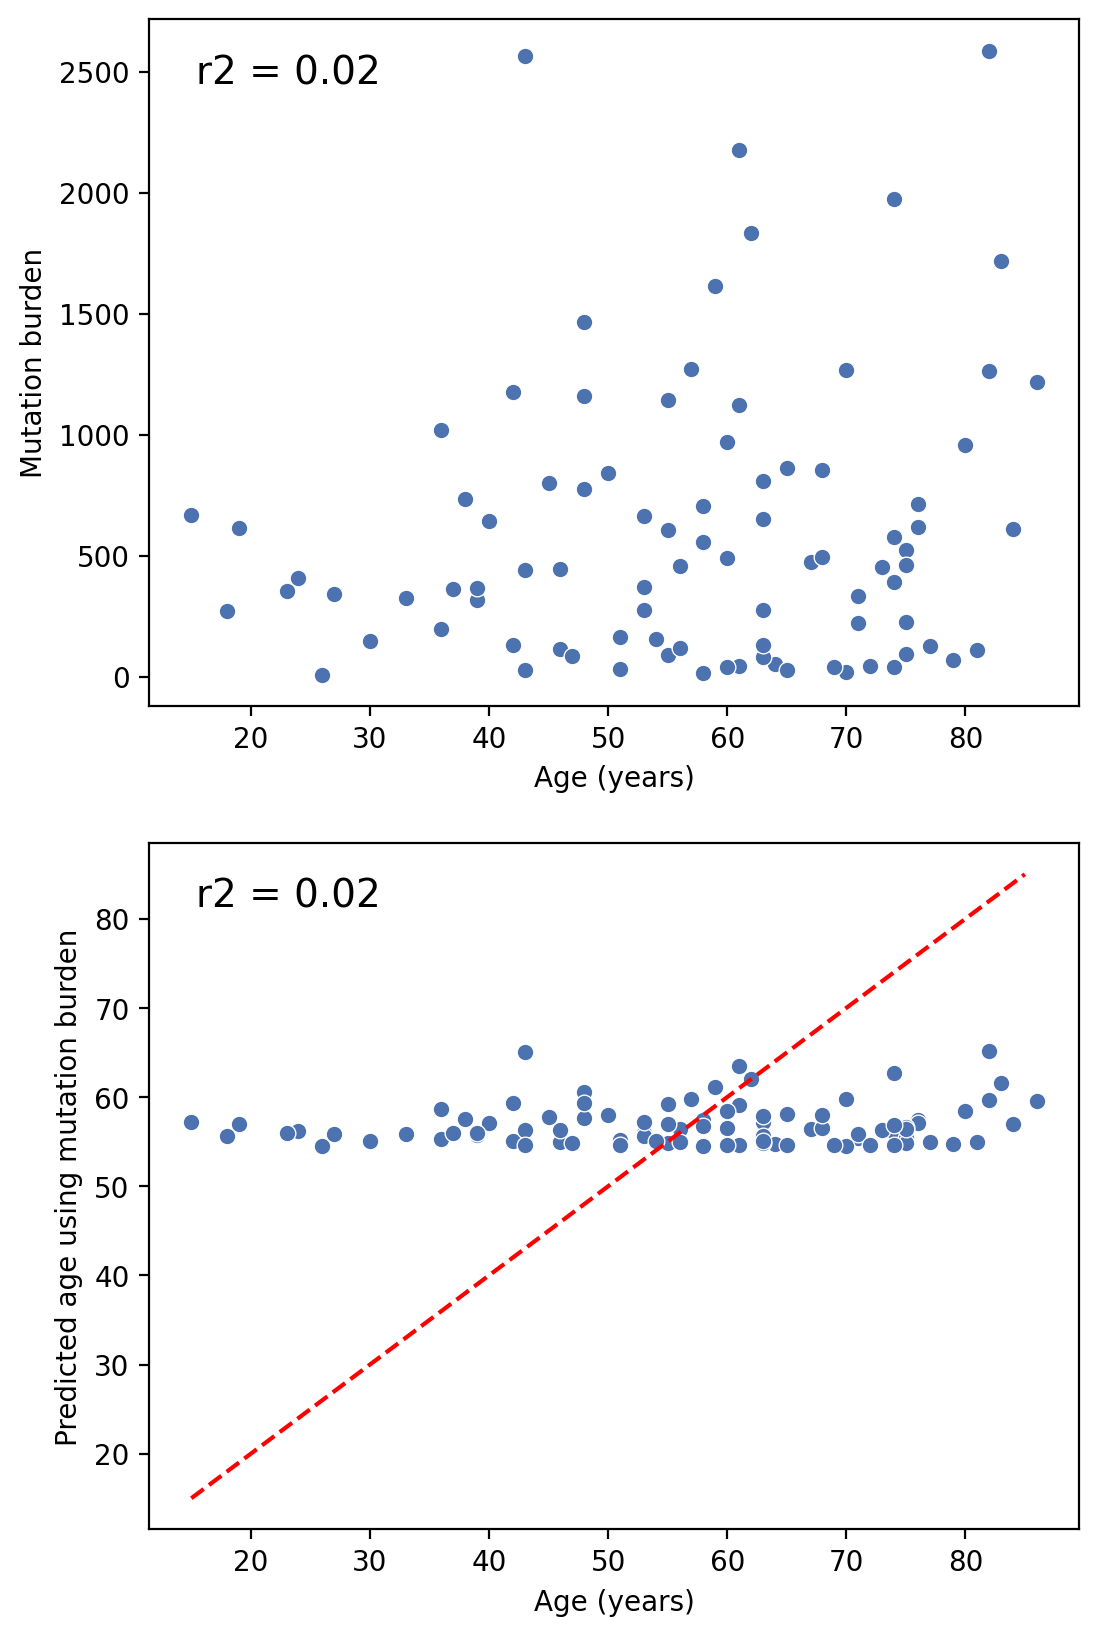

In [44]:
# comparing to mutation burden
fig, axes = plt.subplots(2, 1, figsize=(6, 10), dpi=100)
axes = axes.ravel()
# mut_burden = all_mut_w_age_df['case_submitter_id'].value_counts()
mut_burden = all_mut_w_age_df['case_submitter_id'].value_counts()

outlier_samples = mut_burden[mut_feat.test_samples][mut_burden[mut_feat.test_samples] > 4000].index.to_list()
samples = [x for x in mut_feat.test_samples if x not in outlier_samples]


to_plot_mut_burden = pd.DataFrame({'Age (years)': all_methyl_age_df_t.loc[samples, 'age_at_index'], 'Mutation burden': mut_burden[samples]})

# fit a linear model
lr = LinearRegression()
lr.fit(to_plot_mut_burden['Mutation burden'].values.reshape(-1, 1), to_plot_mut_burden['Age (years)'])
pred_age_by_mut_burden = lr.predict(to_plot_mut_burden['Mutation burden'].values.reshape(-1, 1))
to_plot_mut_burden['Predicted age using mutation burden'] = pred_age_by_mut_burden

sns.scatterplot(data=to_plot_mut_burden, x = 'Age (years)', y = 'Mutation burden', ax = axes[0])
axes[0].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(to_plot_mut_burden['Age (years)'], to_plot_mut_burden['Mutation burden'])[0,1]**2, 3)), transform=axes[0].transAxes, fontsize=14, verticalalignment='top', c= 'black')

sns.scatterplot(data=to_plot_mut_burden, x = 'Age (years)', y = 'Predicted age using mutation burden', ax = axes[1])
axes[1].plot([15,85], [15,85], ls="--", color = 'red')
axes[1].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(to_plot_mut_burden['Age (years)'], to_plot_mut_burden['Predicted age using mutation burden'])[0,1]**2, 3)), transform=axes[1].transAxes, fontsize=14, verticalalignment='top', c= 'black')

In [108]:
mut_clock.performance_df

,testing_methyl_r,testing_methyl_mae,training_real_mf_age_r,training_pred_mf_age_r,training_pred_real_mf_r,testing_scrambled_real_mf_r,testing_pred_mf_age_r,testing_real_mf_age_r
cg00687021,0.557144,0.166054,-0.011359,-0.007200,0.975160,-0.032020,-0.105364,-0.032209
cg18172186,0.524595,0.154347,-0.003580,0.008836,0.909416,0.099349,-0.091619,-0.080232
cg23199797,0.541274,0.137854,0.030485,0.025894,0.960932,0.018559,0.088732,0.092977
cg01945223,0.441289,0.153424,0.019280,0.037253,0.865247,0.017408,0.199479,0.016860
cg09326204,0.097448,0.135574,-0.008559,-0.041136,0.658416,0.142539,-0.235503,0.019952
...,...,...,...,...,...,...,...,...
cg03640756,0.335679,0.169139,0.004772,-0.007215,0.830833,-0.106300,0.136148,0.119041
cg15988320,0.162547,0.142547,0.004341,0.002552,0.889601,-0.020693,0.034758,0.092074
cg12145907,0.384940,0.156369,0.003120,-0.001433,0.863110,0.030528,0.198743,0.183474
cg13234675,0.177824,0.074253,-0.001303,0.015982,0.915942,-0.120498,-0.058833,0.089698


Text(0, 0.5, 'Predicted-methylation age correlation (testing samples)')

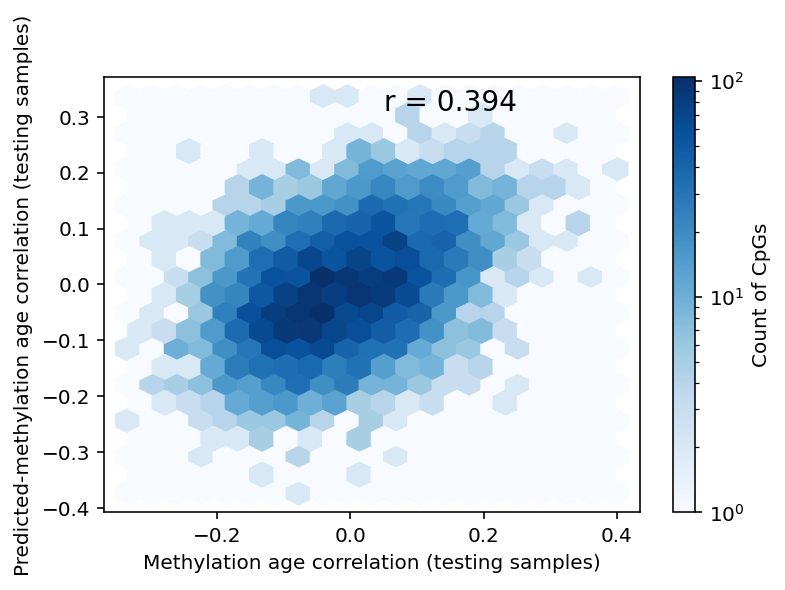

In [119]:
# subset
cpg_subset = mut_clock.performance_df['testing_methyl_r'].nlargest(5000).index
plt.hexbin(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r'], gridsize=20, cmap='Blues', bins = 'log')
# label color bar
plt.colorbar(label='Count of CpGs')
plt.text(0.05, 0.35, 'r = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r'])[0,1], 3)), fontsize=14, verticalalignment='top', c= 'black')
plt.xlabel("Methylation age correlation (testing samples)")
plt.ylabel("Predicted-methylation age correlation (testing samples)")


In [124]:
model = mut_clock.train_epi_clock(X = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples].iloc[:, 3:], y = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])

0.22573954174167338


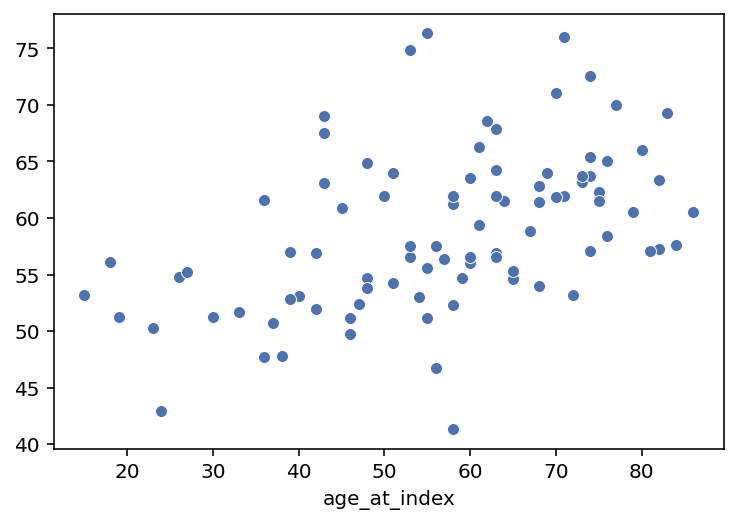

In [126]:
preds = model.predict(mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples].iloc[:, 3:])
sns.scatterplot(x = mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'], y = preds)
print(np.corrcoef(mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'], preds)[0,1]**2)

In [128]:
# leave one out cross validation
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples].iloc[:, 3:])
preds = []
actuals = []
i = 0
for train_index, test_index in loo.split(mut_clock.all_methyl_age_df_t.loc[mut_feat.test_samples].iloc[:, 3:]):
    X_train, X_test = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples].iloc[:, 3:].iloc[train_index], mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples].iloc[:, 3:].iloc[test_index]
    y_train, y_test = mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'].iloc[train_index], mut_clock.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'].iloc[test_index]
    # fit clock 
    model = mut_clock.train_epi_clock(X = X_train, y = y_train)
    # predict
    preds.append(model.predict(X_test))
    actuals.append(y_test)
    print(f"done with {i}", flush=True)
    i += 1

done with 0
done with 1


KeyboardInterrupt: 

Text(0, 0.5, 'Methylation age correlation (testing samples)')

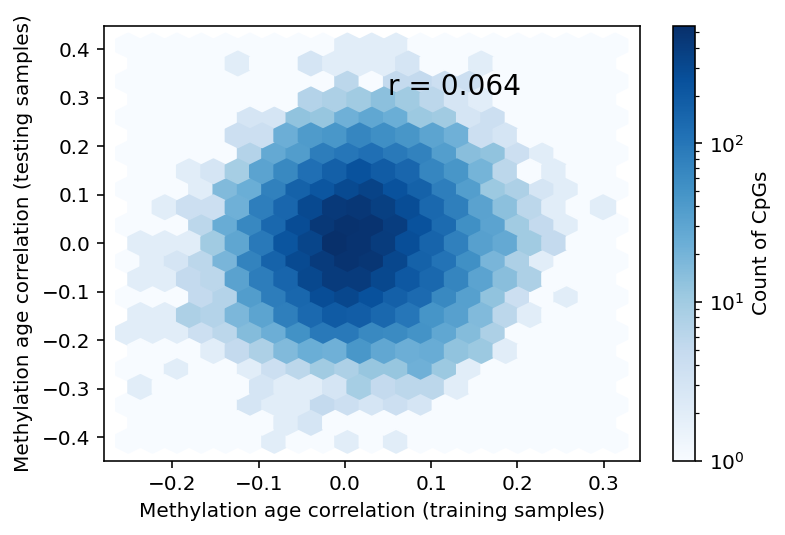

In [120]:
# subset
cpg_subset = mut_clock.performance_df.index
plt.hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r'], mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r'], gridsize=20, cmap='Blues', bins = 'log')
# label color bar
plt.colorbar(label='Count of CpGs')
plt.text(0.05, 0.35, 'r = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r'], mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r'])[0,1], 3)), fontsize=14, verticalalignment='top', c= 'black')
plt.xlabel("Methylation age correlation (training samples)")
plt.ylabel("Methylation age correlation (testing samples)")


Text(0.05, 0.95, 'r2 = 0.028')

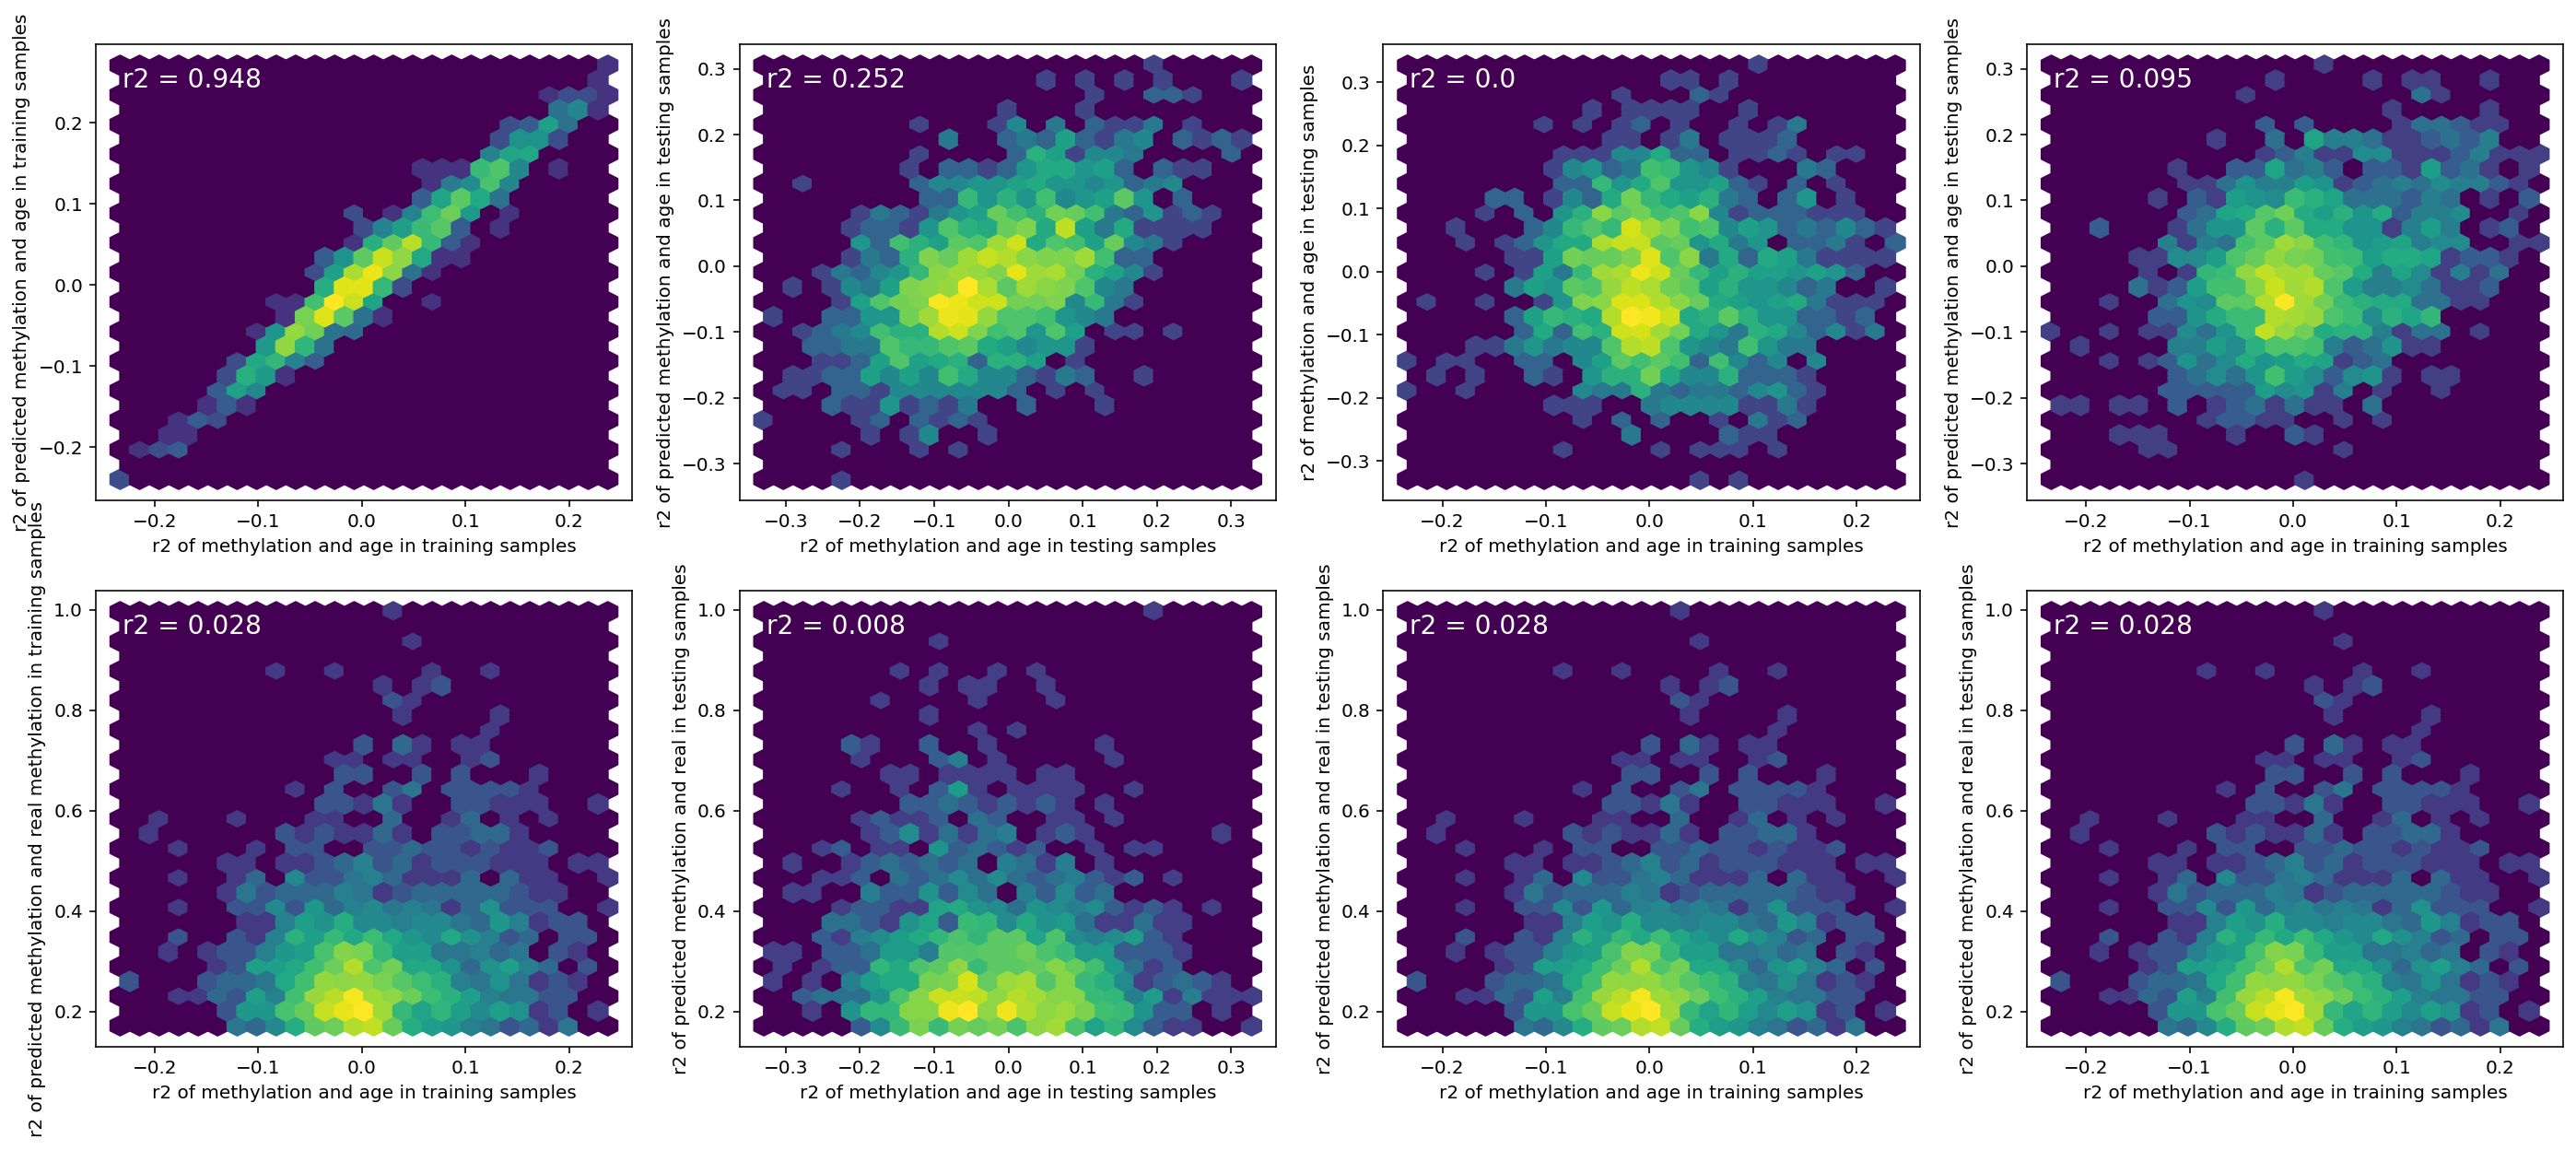

In [103]:
fig, axes = plt.subplots(2,4, figsize=(24,10))
abs_r2 = mut_clock.performance_df['r2'].abs()
cpg_subset = abs_r2.nlargest(2000).index
axes = axes.flatten()
# how does the age corr of predicted methylation in training samples compare to the age corr of real methylation in training samples?
#mut_clock.performance_df['training_pred_mf_age_r2'] = mut_clock.predicted_methyl_df.loc[mut_clock.train_samples,:].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_clock.train_samples, 'age_at_index'])
axes[0].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'training_pred_mf_age_r2'], gridsize=25, bins='log')
axes[0].set_xlabel('r2 of methylation and age in training samples')
axes[0].set_ylabel('r2 of predicted methylation and age in training samples')
axes[0].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'training_pred_mf_age_r2'])[0,1]**2, 3)), transform=axes[0].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# and in testing samples?
#mut_clock.performance_df['testing_pred_mf_age_r2'] = mut_clock.predicted_methyl_df.loc[mut_clock.test_samples,:].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index'])
#mut_clock.performance_df['testing_real_mf_age_r2'] = mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples,mut_clock.predicted_methyl_df.columns].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index'])
# do same plotting and labels
axes[1].hexbin(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2'], gridsize=25, bins='log')
axes[1].set_xlabel('r2 of methylation and age in testing samples')
axes[1].set_ylabel('r2 of predicted methylation and age in testing samples')
axes[1].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2'])[0,1]**2, 3)), transform=axes[1].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# is this because the correlation in training is not the same as testing?
axes[2].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'], gridsize=25, bins='log')
axes[2].set_xlabel('r2 of methylation and age in training samples')
axes[2].set_ylabel('r2 of methylation and age in testing samples')
axes[2].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'])[0,1]**2, 3)), transform=axes[2].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# do the predicted age corrs of testing match the actual age corrs of training?
axes[3].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2'], gridsize=25, bins='log')
axes[3].set_xlabel('r2 of methylation and age in training samples')
axes[3].set_ylabel('r2 of predicted methylation and age in testing samples')
axes[3].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2'])[0,1]**2, 3)), transform=axes[3].transAxes, fontsize=14, verticalalignment='top', c= 'white')

# => the age correlation of methylation sites in training samples does not well represent the testing samples, this is why creating a clock is hard
# => Something thats really good is that even tho the age correlation of methylation sites in training samples does not well represent the testing samples, the age correlation of predicted methylation sites in testing samples does reasonably well repesent the real age correlation of methylation sites in testing samples


axes[4].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'], gridsize=25, bins='log')
axes[4].set_xlabel('r2 of methylation and age in training samples')
axes[4].set_ylabel('r2 of predicted methylation and real methylation in training samples')
axes[4].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'])[0,1]**2, 3)), transform=axes[4].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# and in testing samples?
#mut_clock.performance_df['testing_pred_mf_age_r2'] = mut_clock.predicted_methyl_df.loc[mut_clock.test_samples,:].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index'])
#mut_clock.performance_df['testing_real_mf_age_r2'] = mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples,mut_clock.predicted_methyl_df.columns].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index'])
# do same plotting and labels
axes[5].hexbin(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'], gridsize=25, bins='log')
axes[5].set_xlabel('r2 of methylation and age in testing samples')
axes[5].set_ylabel('r2 of predicted methylation and real in testing samples')
axes[5].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'testing_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'])[0,1]**2, 3)), transform=axes[5].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# is this because the correlation in training is not the same as testing?
axes[6].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'], gridsize=25, bins='log')
axes[6].set_xlabel('r2 of methylation and age in training samples')
axes[6].set_ylabel('r2 of predicted methylation and real in testing samples')
axes[6].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'])[0,1]**2, 3)), transform=axes[6].transAxes, fontsize=14, verticalalignment='top', c= 'white')
# do the predicted age corrs of testing match the actual age corrs of training?
axes[7].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'], gridsize=25, bins='log')
axes[7].set_xlabel('r2 of methylation and age in training samples')
axes[7].set_ylabel('r2 of predicted methylation and real in testing samples')
axes[7].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2'], mut_clock.performance_df.loc[cpg_subset, 'r2'])[0,1]**2, 3)), transform=axes[7].transAxes, fontsize=14, verticalalignment='top', c= 'white')

In [97]:
# calculate age corrs for choosing cpgs
corrs = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
corrs.drop(['age_at_index', 'gender_MALE', 'gender_FEMALE'], inplace=True)
corrs = corrs.to_frame()
corrs.columns = ['corr']
corrs['corr'] = corrs['corr'].abs()
meqtl_counts = godmc_meqtls['cpg'].value_counts().to_frame()
cpg_pred_priority = mut_feat.choose_cpgs_to_train(metric_df = corrs, bin_size = 50000, sort_by=['count', 'corr'], mean = True)
cpg_pred_priority.set_index('#id', inplace=True, drop=True)

mut_clock.performance_df['training_mean_mut_count_50kb_bin'] = cpg_pred_priority.loc[mut_clock.performance_df.index, 'count']

#mut_clock.performance_df['testing_mean_mut_count_50kb_bin'] = cpg_pred_priority.loc[mut_clock.performance_df.index, 'count']


In [118]:
mut_clock.performance_df.corr()

,r2,mae,training_real_mf_age_r2,stdev,training_pred_mf_age_r2,testing_pred_mf_age_r2,testing_real_mf_age_r2,mean_mut_count_50kb_bin,training_mean_mut_count_50kb_bin,testing_mean_mut_count_50kb_bin,all_samp_real_mf_age_r
r2,1.000000,0.128160,-0.003874,0.493493,-0.014684,-0.082856,-0.094542,0.018961,0.018961,0.061798,-0.102055
mae,0.128160,1.000000,0.143713,0.820221,0.159358,0.051873,-0.031079,0.135737,0.135737,0.156995,-0.382223
training_real_mf_age_r2,-0.003874,0.143713,1.000000,0.086013,0.910066,0.172726,0.063833,0.039829,0.039829,0.015865,0.091976
stdev,0.493493,0.820221,0.086013,1.000000,0.098866,0.056580,-0.053060,0.107676,0.107676,0.154069,-0.325606
training_pred_mf_age_r2,-0.014684,0.159358,0.910066,0.098866,1.000000,0.192835,0.036288,0.010306,0.010306,-0.007390,0.061130
testing_pred_mf_age_r2,-0.082856,0.051873,0.172726,0.056580,0.192835,1.000000,0.181480,0.084201,0.084201,0.062666,0.066697
testing_real_mf_age_r2,-0.094542,-0.031079,0.063833,-0.053060,0.036288,0.181480,1.000000,0.098326,0.098326,0.055405,0.099570
mean_mut_count_50kb_bin,0.018961,0.135737,0.039829,0.107676,0.010306,0.084201,0.098326,1.000000,1.000000,0.867687,0.031043
training_mean_mut_count_50kb_bin,0.018961,0.135737,0.039829,0.107676,0.010306,0.084201,0.098326,1.000000,1.000000,0.867687,0.031043
testing_mean_mut_count_50kb_bin,0.061798,0.156995,0.015865,0.154069,-0.007390,0.062666,0.055405,0.867687,0.867687,1.000000,-0.009665


In [111]:
mut_clock.performance_df.loc[mut_clock.performance_df['testing_pred_mf_age_r2'].nlargest(2000).index].corr()

,r2,mae,training_real_mf_age_r2,stdev,training_pred_mf_age_r2,testing_pred_mf_age_r2,testing_real_mf_age_r2,mean_mut_count_50kb_bin,training_mean_mut_count_50kb_bin,testing_mean_mut_count_50kb_bin
r2,1.000000,0.089614,0.168524,0.411193,0.149500,-0.075183,0.186047,-0.050223,-0.050223,-0.039601
mae,0.089614,1.000000,0.256893,0.858176,0.283883,0.145727,0.099410,0.183448,0.183448,0.193437
training_real_mf_age_r2,0.168524,0.256893,1.000000,0.294062,0.918525,0.117303,0.077043,0.107371,0.107371,0.104567
stdev,0.411193,0.858176,0.294062,1.000000,0.318005,0.109104,0.126786,0.083364,0.083364,0.108968
training_pred_mf_age_r2,0.149500,0.283883,0.918525,0.318005,1.000000,0.114898,0.027915,0.017580,0.017580,0.024860
testing_pred_mf_age_r2,-0.075183,0.145727,0.117303,0.109104,0.114898,1.000000,0.077835,0.143083,0.143083,0.127323
testing_real_mf_age_r2,0.186047,0.099410,0.077043,0.126786,0.027915,0.077835,1.000000,0.216050,0.216050,0.193114
mean_mut_count_50kb_bin,-0.050223,0.183448,0.107371,0.083364,0.017580,0.143083,0.216050,1.000000,1.000000,0.946211
training_mean_mut_count_50kb_bin,-0.050223,0.183448,0.107371,0.083364,0.017580,0.143083,0.216050,1.000000,1.000000,0.946211
testing_mean_mut_count_50kb_bin,-0.039601,0.193437,0.104567,0.108968,0.024860,0.127323,0.193114,0.946211,0.946211,1.000000


Text(0.05, 0.95, 'r2 = nan')

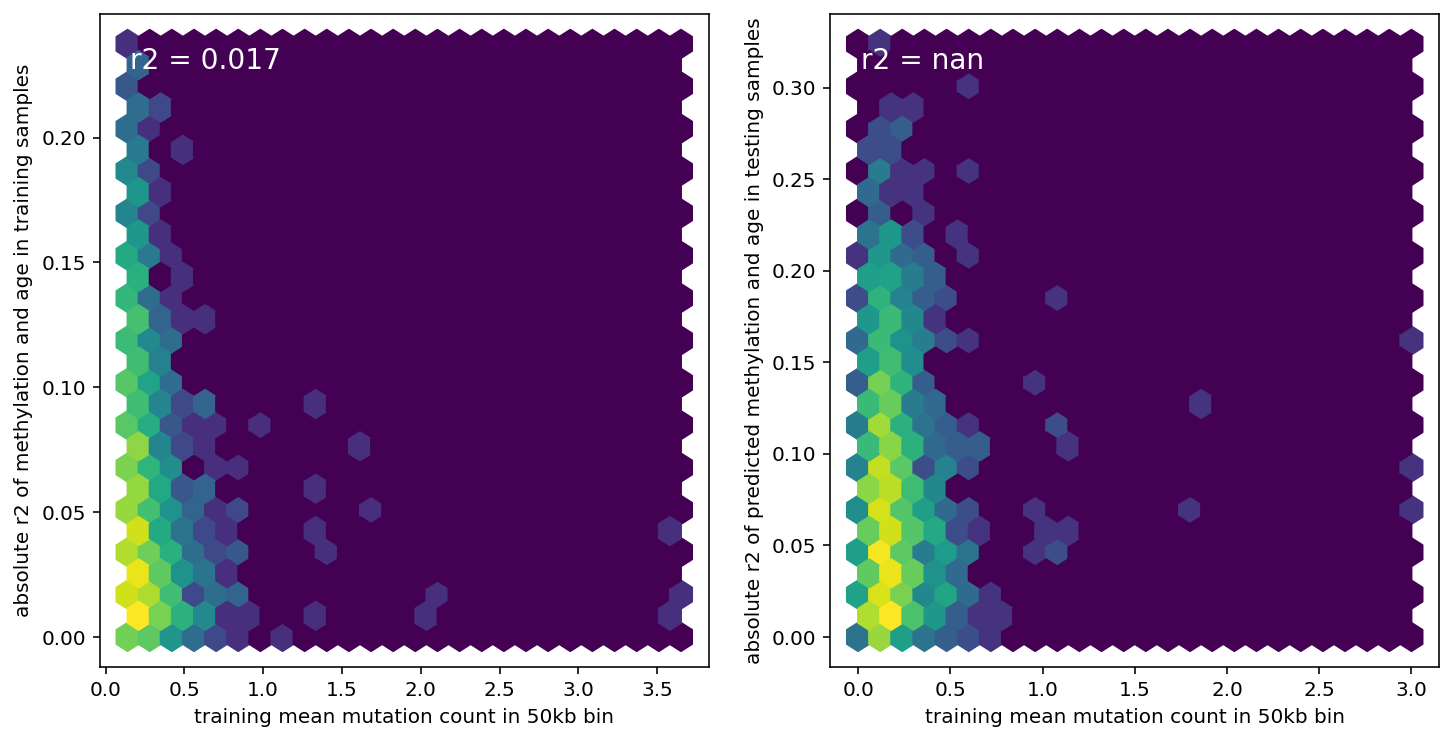

In [104]:
# what is it about the well predicted methylation sites (that also have high stdev) that makes them predictable?
abs_r2 = mut_clock.performance_df['r2'].abs()
cpg_subset = abs_r2.nlargest(2000).index

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].hexbin(mut_clock.performance_df.loc[cpg_subset, 'training_mean_mut_count_50kb_bin'], np.abs(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2']), gridsize=25, bins='log')
axes[0].set_xlabel('training mean mutation count in 50kb bin')
axes[0].set_ylabel('absolute r2 of methylation and age in training samples')
# add r2
axes[0].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'training_mean_mut_count_50kb_bin'], np.abs(mut_clock.performance_df.loc[cpg_subset, 'training_real_mf_age_r2']))[0,1]**2, 3)), transform=axes[0].transAxes, fontsize=14, verticalalignment='top', c= 'white')

axes[1].hexbin(mut_clock.performance_df.loc[cpg_subset, 'testing_mean_mut_count_50kb_bin'], np.abs(mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2']), gridsize=25, bins='log')
axes[1].set_xlabel('training mean mutation count in 50kb bin')
axes[1].set_ylabel('absolute r2 of predicted methylation and age in testing samples')
# add r2
axes[1].text(0.05, 0.95, 'r2 = ' + str(round(np.corrcoef(mut_clock.performance_df.loc[cpg_subset, 'testing_mean_mut_count_50kb_bin'], np.abs(mut_clock.performance_df.loc[cpg_subset, 'testing_pred_mf_age_r2']))[0,1]**2, 3)), transform=axes[1].transAxes, fontsize=14, verticalalignment='top', c= 'white')

In [11]:
training_age_corr = mut_clock.feature_selection()
training_age_corr = training_age_corr.to_frame()
training_age_corr.columns = ['age_corr']
training_age_corr['abs_age_corr'] = np.abs(training_age_corr['age_corr'])
training_age_corr.sort_values('abs_age_corr', ascending=False, inplace=True)

In [30]:
training_age_corr = mut_clock.predicted_methyl_df.loc[mut_feat.train_samples, :].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
testing_age_corr = mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, :].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'])
actual_training_age_corr = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, mut_clock.predicted_methyl_df.columns].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index'])
actual_testing_age_corr = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, mut_clock.predicted_methyl_df.columns].corrwith(mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'])

In [ ]:
# training on real methylation 
for top_cpgs in [100, 1000, 10000, 50000, 100000]:
    for samples in [mut_clock.train_samples, mut_clock.all_methyl_age_df_t.loc[mut_clock.all_methyl_age_df_t.index.difference(mut_clock.test_samples)].index]:
        mut_clock.train_epi_clock(
            samples = samples,
            cpgs = training_age_corr.head(top_cpgs).index,
            out_fn = f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/cpgs{top_cpgs}_samples{len(samples)}_epi_clock_.pkl"
            )
        print(f"Top {top_cpgs} cpgs", flush=True)

In [43]:
# models trained on real methylation data
model_predictions = {}
for top_cpgs in [100, 1000, 10000, 50000, 100000]:
    for samples in [mut_clock.train_samples, mut_clock.all_methyl_age_df_t.loc[mut_clock.all_methyl_age_df_t.index.difference(mut_clock.test_samples)].index]:
        # read in model and predict testing data
        model = pickle.load(open(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/cpgs{top_cpgs}_samples{len(samples)}_epi_clock_.pkl", 'rb'))
        # get feature names from model
        preds = model.predict(mut_clock.predicted_methyl_df.loc[mut_clock.test_samples, model.feature_names_in_])
        model_predictions[f"top{top_cpgs}_samples{len(samples)}"] = preds
        actual_methyl_preds = model.predict(mut_clock.all_methyl_age_df_t.loc[mut_clock.test_samples, model.feature_names_in_])
        model_predictions[f"actual_top{top_cpgs}_samples{len(samples)}"] = actual_methyl_preds
        print(f"Done with top {top_cpgs} cpgs and {len(samples)} samples", flush=True)

Done with top 100 cpgs and 370 samples
Done with top 100 cpgs and 8690 samples
Done with top 1000 cpgs and 370 samples
Done with top 1000 cpgs and 8690 samples
Done with top 10000 cpgs and 370 samples
Done with top 10000 cpgs and 8690 samples
Done with top 50000 cpgs and 370 samples
Done with top 50000 cpgs and 8690 samples
Done with top 100000 cpgs and 370 samples
Done with top 100000 cpgs and 8690 samples


In [56]:
model_predictions_df = pd.DataFrame(model_predictions, index = mut_clock.test_samples)
model_predictions_df['actual'] = mut_clock.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index']
# correlation of each predictoin witha actual age
model_predictions_df.corr()['actual']

top100_samples370               0.292798
actual_top100_samples370        0.193354
top100_samples8690              0.248891
actual_top100_samples8690       0.005608
top1000_samples370              0.294876
actual_top1000_samples370       0.226529
top1000_samples8690             0.280894
actual_top1000_samples8690      0.171007
top10000_samples370             0.284039
actual_top10000_samples370      0.235491
top10000_samples8690            0.277765
actual_top10000_samples8690     0.420527
top50000_samples370             0.271964
actual_top50000_samples370      0.326023
top50000_samples8690            0.214165
actual_top50000_samples8690     0.533031
top100000_samples370            0.252827
actual_top100000_samples370     0.302445
top100000_samples8690           0.273276
actual_top100000_samples8690    0.582442
actual                          1.000000
Name: actual, dtype: float64

In [106]:
# training on predicted methylation in training samples
model_predictions = {}
for top_cpgs in [100, 1000, 10000]:
    model = mut_clock.train_epi_clock(
        samples = mut_clock.train_samples,
        cpgs = training_age_corr.abs().nlargest(top_cpgs).index,
        out_fn = f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/cpgs{top_cpgs}_samples{len(samples)}_epi_clock_.pkl"
        )
    model_predictions[f"top {top_cpgs}"] = model.predict(mut_clock.predicted_methyl_df.loc[mut_clock.test_samples, model.feature_names_in_])
    print(f"Top {top_cpgs} cpgs", flush=True)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    0.8s


Top 100 cpgs


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    1.5s


Top 1000 cpgs


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    2.1s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    8.9s


Top 10000 cpgs


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   13.2s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    0.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    0.1s
[Parallel(n_jobs=64)]: Done 1000 out of 1000 | elapsed:    0.1s finished


In [75]:
model_predictions_df = pd.DataFrame(model_predictions, index = mut_clock.test_samples)
model_predictions_df['actual'] = mut_clock.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index']
# correlation of each predictoin witha actual age
model_predictions_df.corr()['actual']

top 100       0.287423
top 1000      0.303622
top 10000     0.146378
top 100000    0.088153
actual        1.000000
Name: actual, dtype: float64

In [107]:
model_predictions_df = pd.DataFrame(model_predictions, index = mut_clock.test_samples)
model_predictions_df['actual'] = mut_clock.all_methyl_age_df_t.loc[mut_clock.test_samples, 'age_at_index']
# correlation of each predictoin witha actual age
model_predictions_df.corr()['actual']

top 100      0.294314
top 1000     0.310337
top 10000    0.309447
actual       1.000000
Name: actual, dtype: float64

In [90]:
model_predictions_df

,top 100,top 1000,top 10000,top 100000,actual
TCGA-3N-A9WB,60.164069,58.411348,59.950241,59.579371,71
TCGA-3N-A9WC,62.625750,62.457207,63.991712,64.466419,82
TCGA-3N-A9WD,60.256362,59.161617,58.341141,57.745003,82
TCGA-BF-A1PU,40.914636,42.929406,43.825927,45.148585,46
TCGA-BF-A1PV,60.648132,61.363742,62.409856,62.411224,74
...,...,...,...,...,...
TCGA-D3-A8GJ,58.828907,58.527622,58.548275,58.293899,18
TCGA-D3-A8GK,62.104323,60.398961,57.322299,65.272096,45
TCGA-D3-A8GL,59.486383,62.001434,80.688059,122.711582,43
TCGA-D3-A8GM,65.191339,67.569822,62.920975,62.268771,73


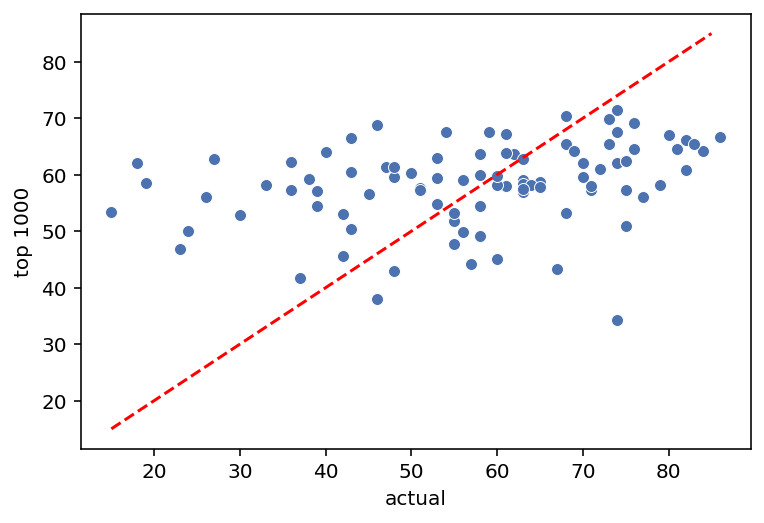

In [108]:
sns.scatterplot(data = model_predictions_df, x = 'actual', y = 'top 1000')
# plot y=x
plt.plot([15, 85], [15, 85], color='red', linestyle='--')

#### LOO epi clock on predicted testing samples

In [124]:
X = mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, :]
y = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']

In [128]:
# import leave one out cross validation
from sklearn.model_selection import LeaveOneOut

In [ ]:
# do leave on out cross validation on X and y
loo = LeaveOneOut()
# get predictions for each leave one out
loo_predictions = []
loo_actual = []
i= 0
for train_index, test_index in loo.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = mut_clock.train_epi_clock(X = X_train, y = y_train)
    loo_predictions.append(model.predict(X_test))
    loo_actual.append(y_test)
    print(f"done {i}")
    i+=1

In [141]:
loo_predictions_l = [i[0] for i in loo_predictions]
loo_actual_l = [i[0] for i in loo_actual]

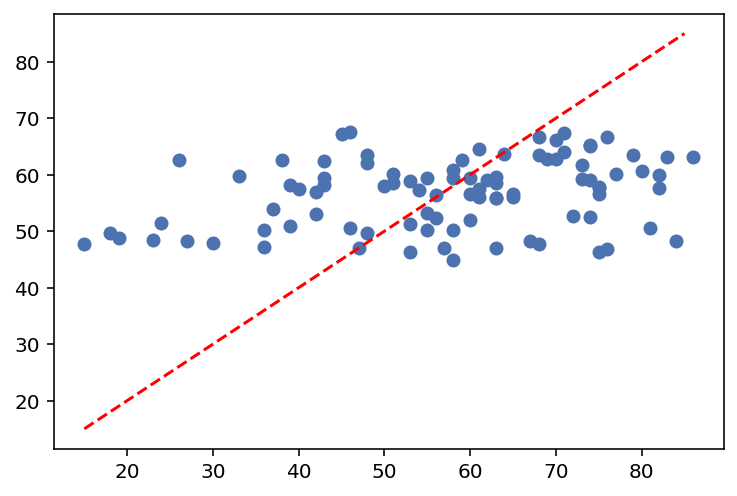

In [144]:
plt.scatter(loo_actual_l, loo_predictions_l)
# y=x line
plt.plot([15, 85], [15, 85], color='red', linestyle='--')

In [194]:
y_test = mut_feat.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
y_train = mut_feat.all_methyl_age_df_t.loc[mut_feat.train_samples, 'age_at_index']

X_test_pred_methyl = mut_clock.predicted_methyl_df.loc[mut_feat.test_samples, :]
X_test_real_methyl= mut_clock.all_methyl_age_df_t.loc[mut_clock.test_samples, mut_clock.predicted_methyl_df.columns]
X_train_pred_methyl = mut_clock.predicted_methyl_df.loc[mut_feat.train_samples, :]
X_train_real_methyl= mut_clock.all_methyl_age_df_t.loc[mut_clock.train_samples, mut_clock.predicted_methyl_df.columns]

real_methyl_model_test = mut_clock.train_epi_clock(X = X_test_real_methyl, y = y_test)
real_test_predicting_pred_test = real_methyl_model_test.predict(X_test_pred_methyl)
real_test_predicting_real_test = real_methyl_model_test.predict(X_test_real_methyl)
real_test_predicting_real_train = real_methyl_model_test.predict(X_train_real_methyl)
real_test_predicting_pred_train = real_methyl_model_test.predict(X_train_pred_methyl)

pred_methyl_model_test = mut_clock.train_epi_clock(X = X_test_pred_methyl, y = y_test)
pred_test_predicting_pred_test = pred_methyl_model_test.predict(X_test_pred_methyl)
pred_test_predicting_real_test = pred_methyl_model_test.predict(X_test_real_methyl)
pred_test_predicting_real_train = pred_methyl_model_test.predict(X_train_real_methyl)
pred_test_predicting_pred_train = pred_methyl_model_test.predict(X_train_pred_methyl)

real_methyl_model_train = mut_clock.train_epi_clock(X = X_train_real_methyl, y = y_train)
real_train_predicting_pred_test = real_methyl_model_train.predict(X_test_pred_methyl)
real_train_predicting_real_test = real_methyl_model_train.predict(X_test_real_methyl)
real_train_predicting_real_train = real_methyl_model_train.predict(X_train_real_methyl)
real_train_predicting_pred_train = real_methyl_model_train.predict(X_train_pred_methyl)

pred_methyl_model_train = mut_clock.train_epi_clock(X = X_train_pred_methyl, y = y_train)
pred_train_predicting_pred_test = pred_methyl_model_train.predict(X_test_pred_methyl)
pred_train_predicting_real_test = pred_methyl_model_train.predict(X_test_real_methyl)
pred_train_predicting_real_train = pred_methyl_model_train.predict(X_train_real_methyl)
pred_train_predicting_pred_train = pred_methyl_model_train.predict(X_train_pred_methyl)

In [201]:
# combine all of the predictions on test into a dataframe
test_predictions_df = pd.DataFrame({'real_test_predicting_real_test': real_test_predicting_real_test, 'pred_test_predicting_real_test': pred_test_predicting_real_test, 'real_train_predicting_real_test': real_train_predicting_real_test, 'pred_train_predicting_real_test': pred_train_predicting_real_test, 'Actual ages': y_test})
train_predictions_df = pd.DataFrame({'real_test_predicting_real_train': real_test_predicting_real_train, 'pred_test_predicting_real_train': pred_test_predicting_real_train, 'real_train_predicting_real_train': real_train_predicting_real_train, 'pred_train_predicting_real_train': pred_train_predicting_real_train, 'Actual ages': y_train})

Text(0.5, 1.0, 'Pred methyl model train r2 = -0.024886189954536286')

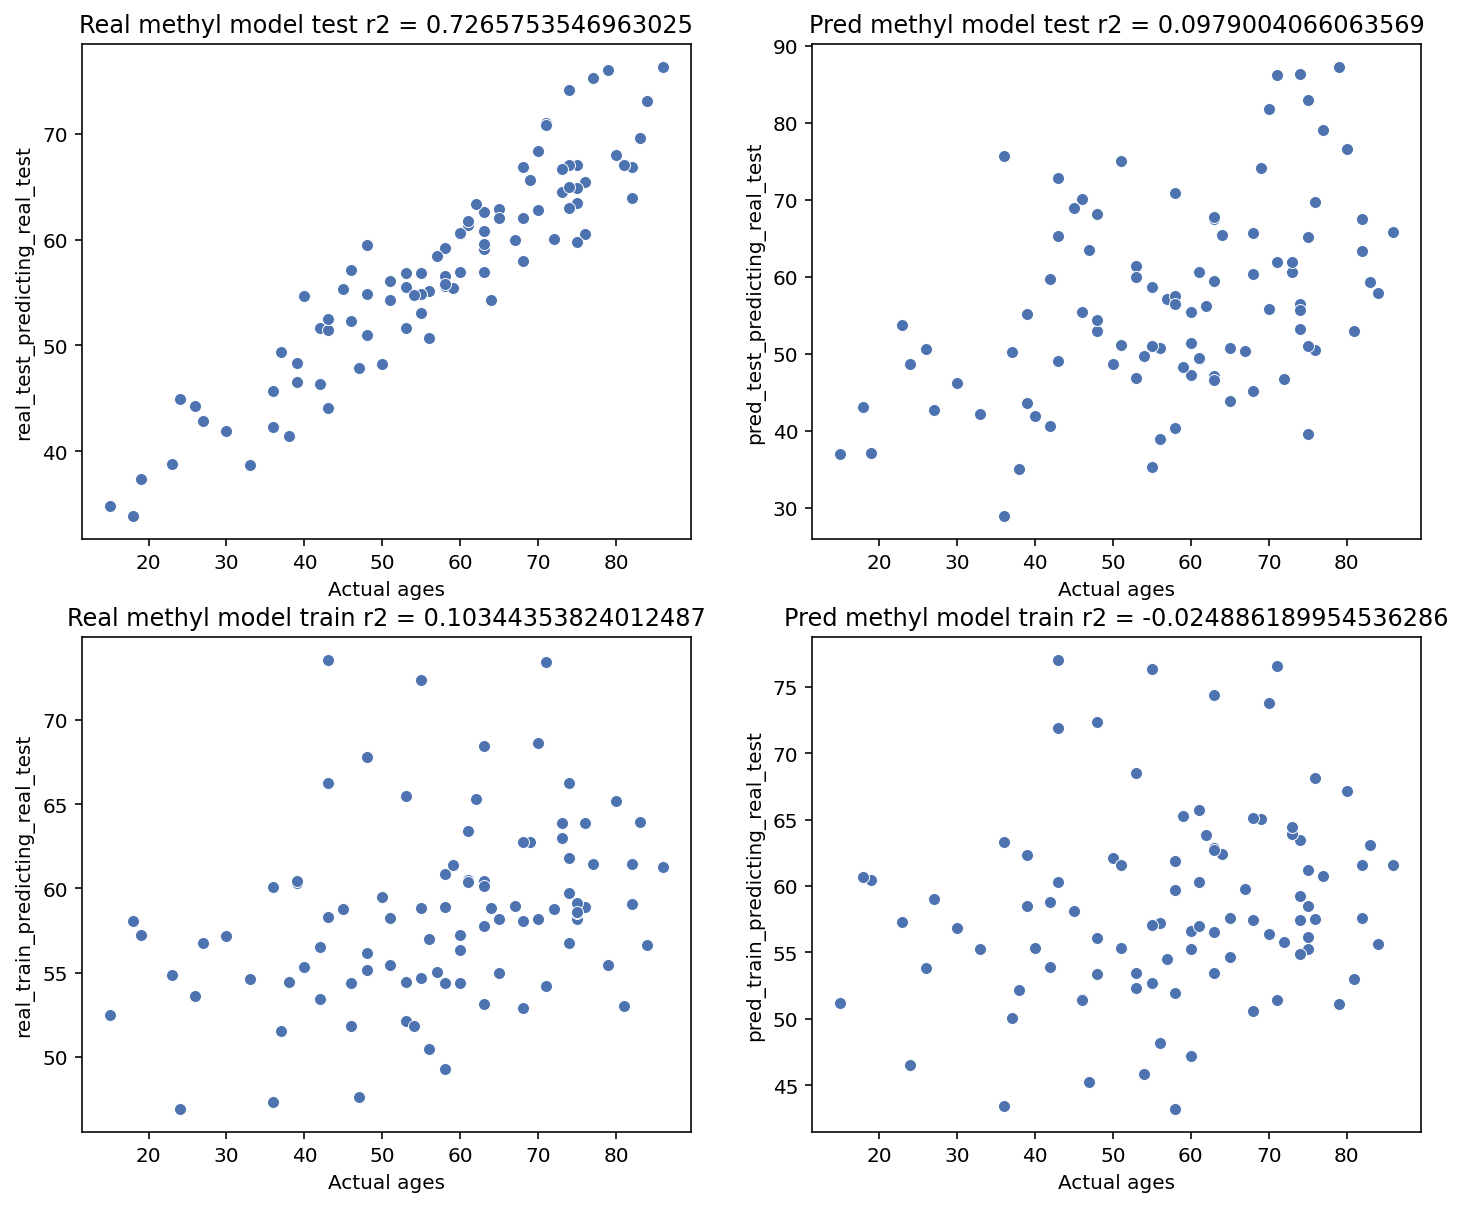

In [202]:
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
# import r2 socre
from sklearn.metrics import r2_score
# plot scatter plot for each result
sns.scatterplot(x = 'Actual ages', y = 'real_test_predicting_real_test', data = test_predictions_df, ax = axes[0, 0])
sns.scatterplot(x = 'Actual ages', y = 'pred_test_predicting_real_test', data = test_predictions_df, ax = axes[0, 1])
sns.scatterplot(x = 'Actual ages', y = 'real_train_predicting_real_test', data = test_predictions_df, ax = axes[1, 0])
sns.scatterplot(x = 'Actual ages', y = 'pred_train_predicting_real_test', data = test_predictions_df, ax = axes[1, 1])
# add r2 to each of these
axes[0, 0].set_title(f"Real methyl model test r2 = {r2_score(test_predictions_df['Actual ages'], test_predictions_df['real_test_predicting_real_test'])}")
axes[0, 1].set_title(f"Pred methyl model test r2 = {r2_score(test_predictions_df['Actual ages'], test_predictions_df['pred_test_predicting_real_test'])}")
axes[1, 0].set_title(f"Real methyl model train r2 = {r2_score(test_predictions_df['Actual ages'], test_predictions_df['real_train_predicting_real_test'])}")
axes[1, 1].set_title(f"Pred methyl model train r2 = {r2_score(test_predictions_df['Actual ages'], test_predictions_df['pred_train_predicting_real_test'])}")


Text(0.5, 1.0, 'Pred methyl model train r2 = 0.4627338814754901')

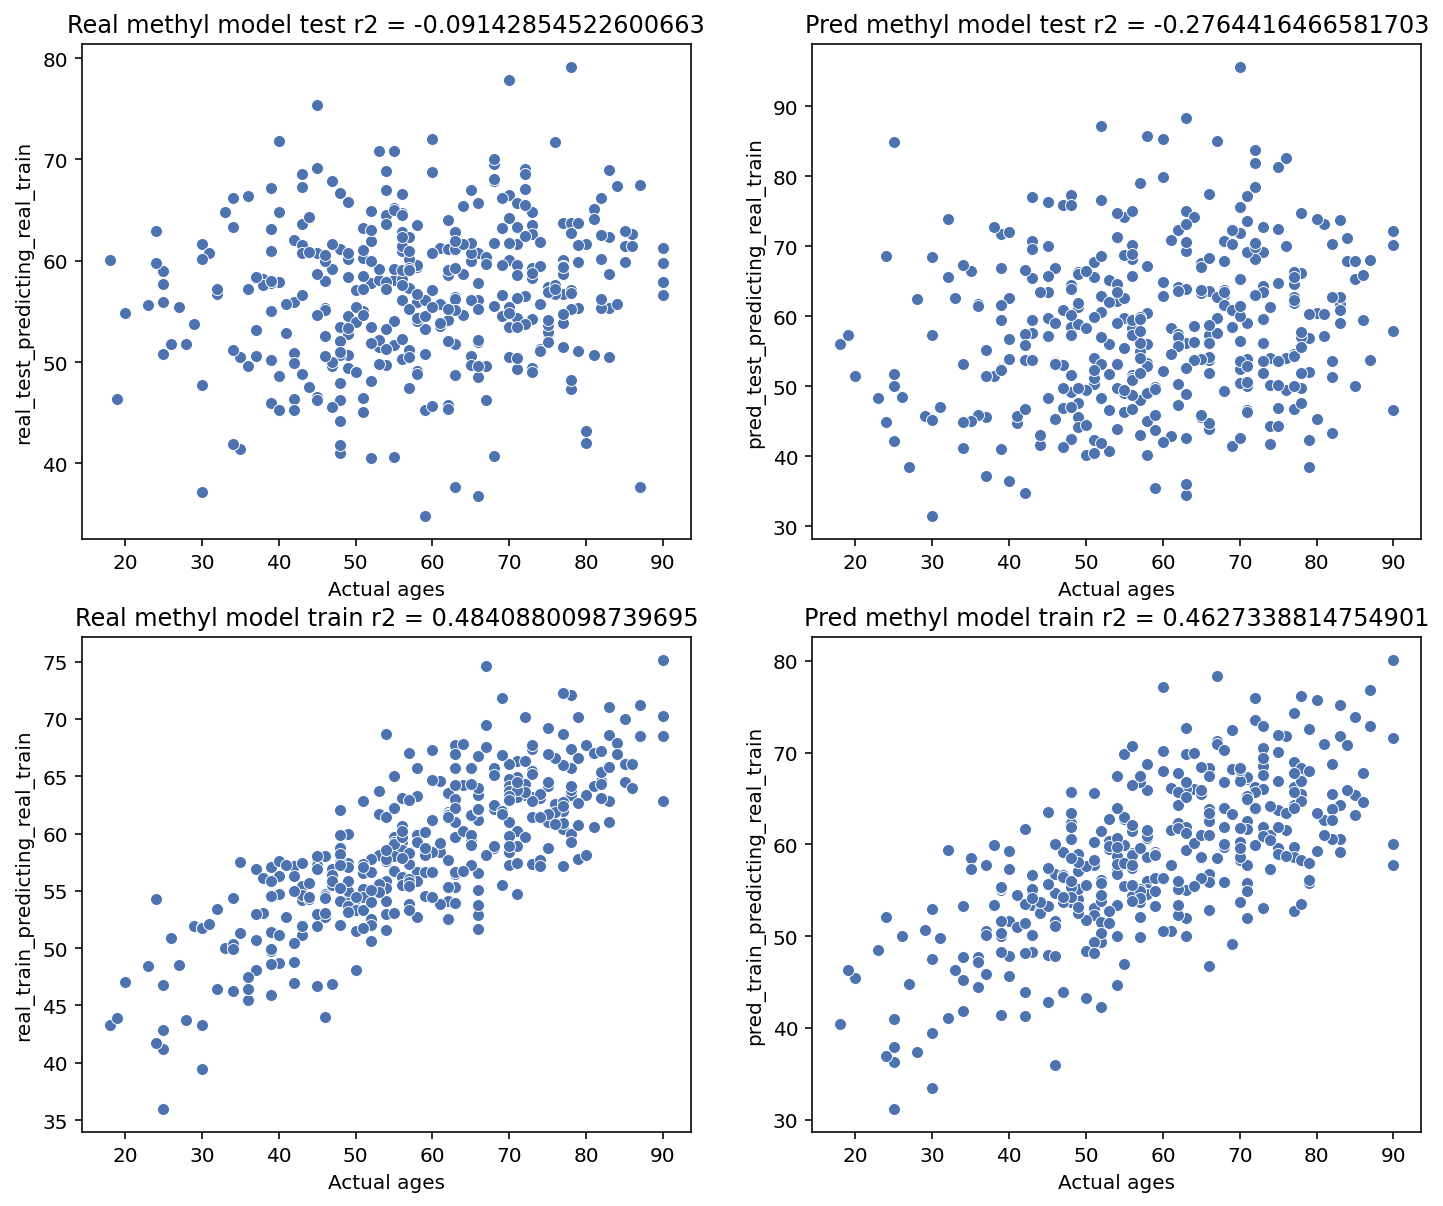

In [203]:
# same thing for predictions of train data
fig, axes = plt.subplots(2, 2, figsize = (12, 10))
# import r2 socre
from sklearn.metrics import r2_score
# plot scatter plot for each result
sns.scatterplot(x = 'Actual ages', y = 'real_test_predicting_real_train', data = train_predictions_df, ax = axes[0, 0])
sns.scatterplot(x = 'Actual ages', y = 'pred_test_predicting_real_train', data = train_predictions_df, ax = axes[0, 1])
sns.scatterplot(x = 'Actual ages', y = 'real_train_predicting_real_train', data = train_predictions_df, ax = axes[1, 0])
sns.scatterplot(x = 'Actual ages', y = 'pred_train_predicting_real_train', data = train_predictions_df, ax = axes[1, 1])
# add r2 to each of these
axes[0, 0].set_title(f"Real methyl model test r2 = {r2_score(train_predictions_df['Actual ages'], train_predictions_df['real_test_predicting_real_train'])}")
axes[0, 1].set_title(f"Pred methyl model test r2 = {r2_score(train_predictions_df['Actual ages'], train_predictions_df['pred_test_predicting_real_train'])}")
axes[1, 0].set_title(f"Real methyl model train r2 = {r2_score(train_predictions_df['Actual ages'], train_predictions_df['real_train_predicting_real_train'])}")
axes[1, 1].set_title(f"Pred methyl model train r2 = {r2_score(train_predictions_df['Actual ages'], train_predictions_df['pred_train_predicting_real_train'])}")

In [217]:
best_predicted_cpgs = mut_clock.performance_df['r2'].nlargest(2000).index

In [218]:
"""X_test_pred_methyl
X_test_real_methyl
X_train_pred_methyl
X_train_real_methyl"""

# use both the real and predicted training samples to train clock
model = mut_clock.train_epi_clock(X = pd.concat([X_train_real_methyl[best_predicted_cpgs], X_train_pred_methyl[best_predicted_cpgs]]), y = pd.concat([y_train, y_train]))

array([[1.        , 0.31069246],
       [0.31069246, 1.        ]])

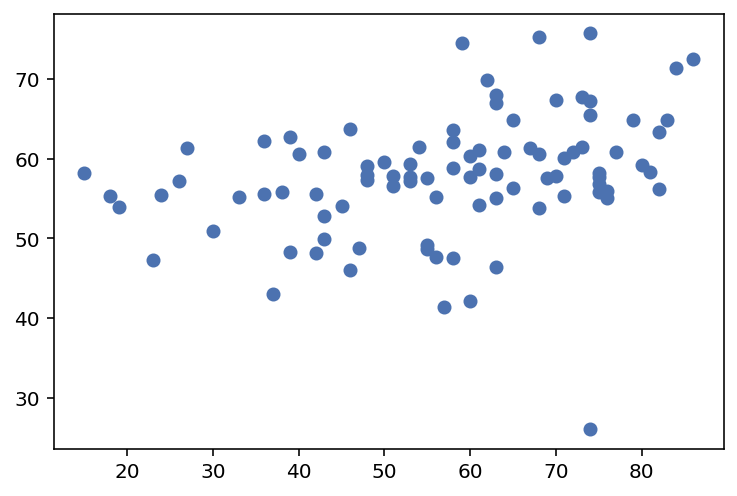

In [209]:
preds = model.predict(X_test_pred_methyl)
plt.scatter(y_test, preds)
np.corrcoef(y_test, preds)

array([[1.        , 0.32630679],
       [0.32630679, 1.        ]])

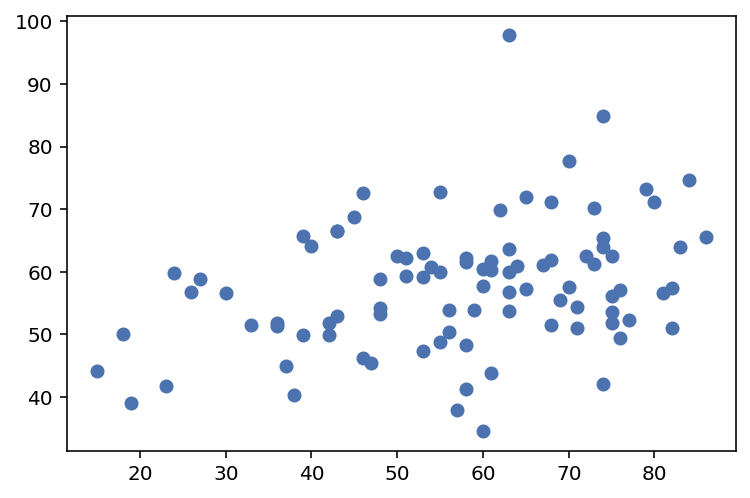

In [220]:
# best pred
preds = model.predict(X_test_pred_methyl[best_predicted_cpgs])
plt.scatter(y_test, preds)
np.corrcoef(y_test, preds)

In [221]:
model = mut_clock.train_epi_clock(X = pd.concat([X_train_real_methyl[best_predicted_cpgs], X_test_real_methyl[best_predicted_cpgs]]), y = pd.concat([y_train, y_test]))
preds = model.predict(X_test_pred_methyl[best_predicted_cpgs])

array([[1.        , 0.36509382],
       [0.36509382, 1.        ]])

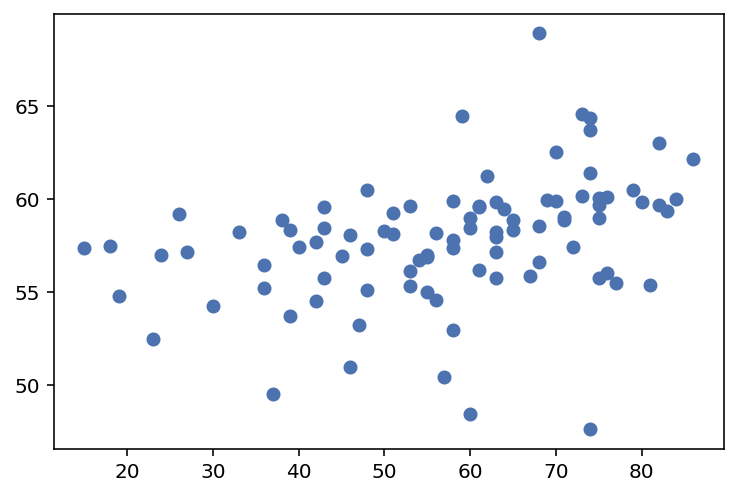

In [211]:
plt.scatter(y_test, preds)
np.corrcoef(y_test, preds)

In [225]:
model = mut_clock.train_epi_clock(X = X_test_real_methyl, y = y_test)
preds = model.predict(X_test_pred_methyl)

array([[1.        , 0.48540515],
       [0.48540515, 1.        ]])

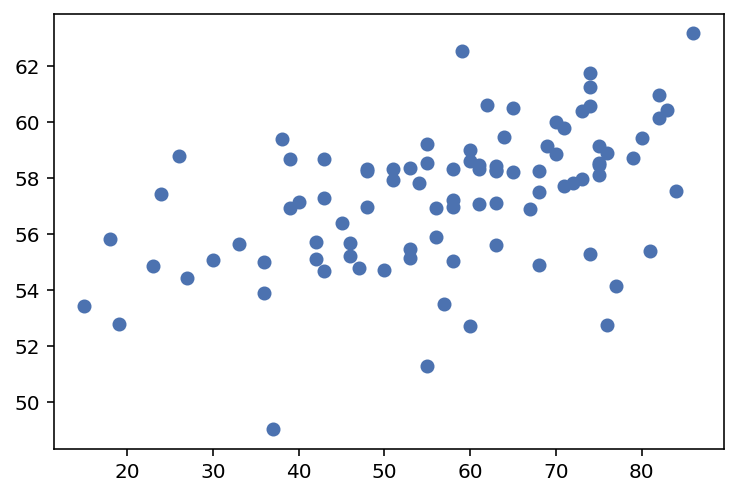

In [226]:
plt.scatter(y_test, preds)
np.corrcoef(y_test, preds)

array([[1.        , 0.63810474],
       [0.63810474, 1.        ]])

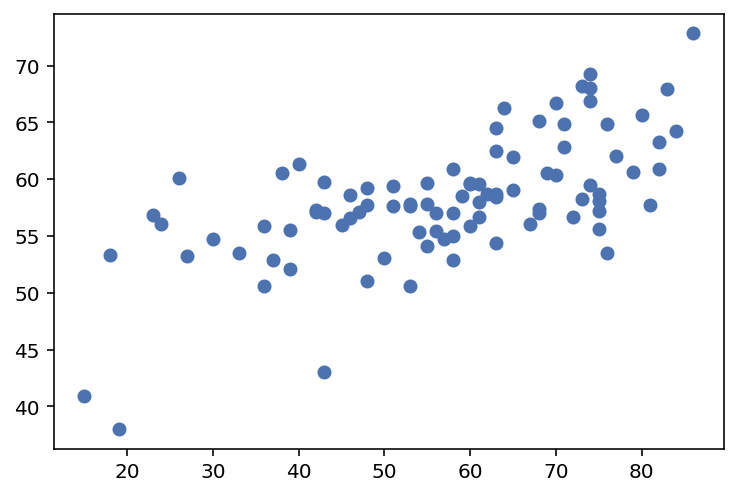

In [224]:
#best pred
plt.scatter(y_test, preds)
np.corrcoef(y_test, preds)

In [285]:
mut_clock.performance_df['r2_training'] = mut_clock.predicted_methyl_df.loc[mut_feat.train_samples].corrwith(all_methyl_age_df_t.loc[mut_feat.train_samples,mut_clock.predicted_methyl_df.columns ])

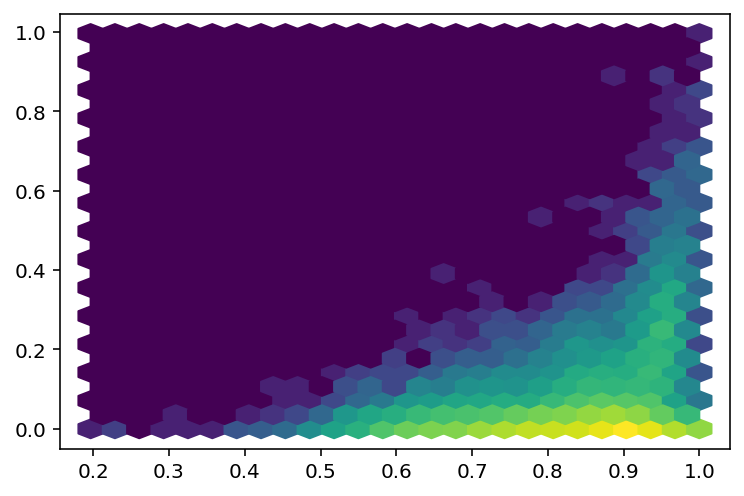

In [296]:
plt.hexbin(mut_clock.performance_df['r2_training'], mut_clock.performance_df['r2'], gridsize = 25, bins = 'log')

In [289]:
pred_by_cpg_num = {}
for best_num in [100, 500, 1000, 2500, 5000, 10000]:
    best_predicted_cpgs = mut_clock.performance_df['r2_training'].nlargest(best_num).index
    model = mut_clock.train_epi_clock(X = X_test_real_methyl[best_predicted_cpgs], y = y_test)
    preds = model.predict(X_test_pred_methyl[best_predicted_cpgs])
    pred_by_cpg_num[best_num] = preds
pred_by_cpg_num['actual'] = y_test
pred_by_cpg_num_df = pd.DataFrame(pred_by_cpg_num)
pred_by_cpg_num_df.corr()

,100,500,1000,2500,5000,10000,actual
100,1.000000,0.678313,0.278932,0.015162,0.083450,0.103010,0.096098
500,0.678313,1.000000,0.470134,0.266651,0.359720,0.300398,0.174227
1000,0.278932,0.470134,1.000000,0.752853,0.727831,0.648616,0.583941
2500,0.015162,0.266651,0.752853,1.000000,0.921249,0.827028,0.611261
5000,0.083450,0.359720,0.727831,0.921249,1.000000,0.908618,0.641640
10000,0.103010,0.300398,0.648616,0.827028,0.908618,1.000000,0.594051
actual,0.096098,0.174227,0.583941,0.611261,0.641640,0.594051,1.000000


In [331]:
pred_by_cpg_num2 = {}
for best_num in [5000]:#[2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]:
    best_predicted_cpgs = mut_clock.performance_df['r2_training'].nlargest(best_num).index
    model = mut_clock.train_epi_clock(X = X_test_real_methyl[best_predicted_cpgs], y = y_test)
    preds = model.predict(X_test_pred_methyl[best_predicted_cpgs])
    pred_by_cpg_num2[best_num] = preds
pred_by_cpg_num2['actual'] = y_test
pred_by_cpg_num2_df = pd.DataFrame(pred_by_cpg_num2)
pred_by_cpg_num2_df.corr()

Number of non-zero coefficients:  899


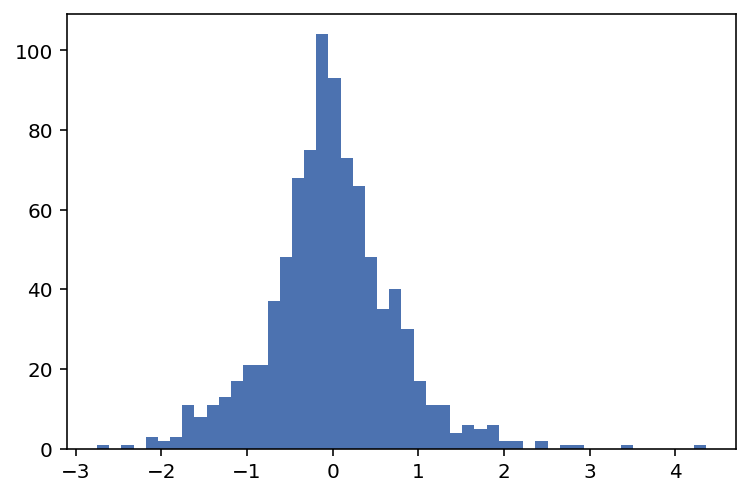

In [304]:
final_model = model
_ = plt.hist(final_model.coef_[final_model.coef_ != 0], bins=50)
print("Number of non-zero coefficients: ", len(final_model.coef_[final_model.coef_ != 0]))
feature_names_of_nonzero = final_model.feature_names_in_[final_model.coef_ != 0]

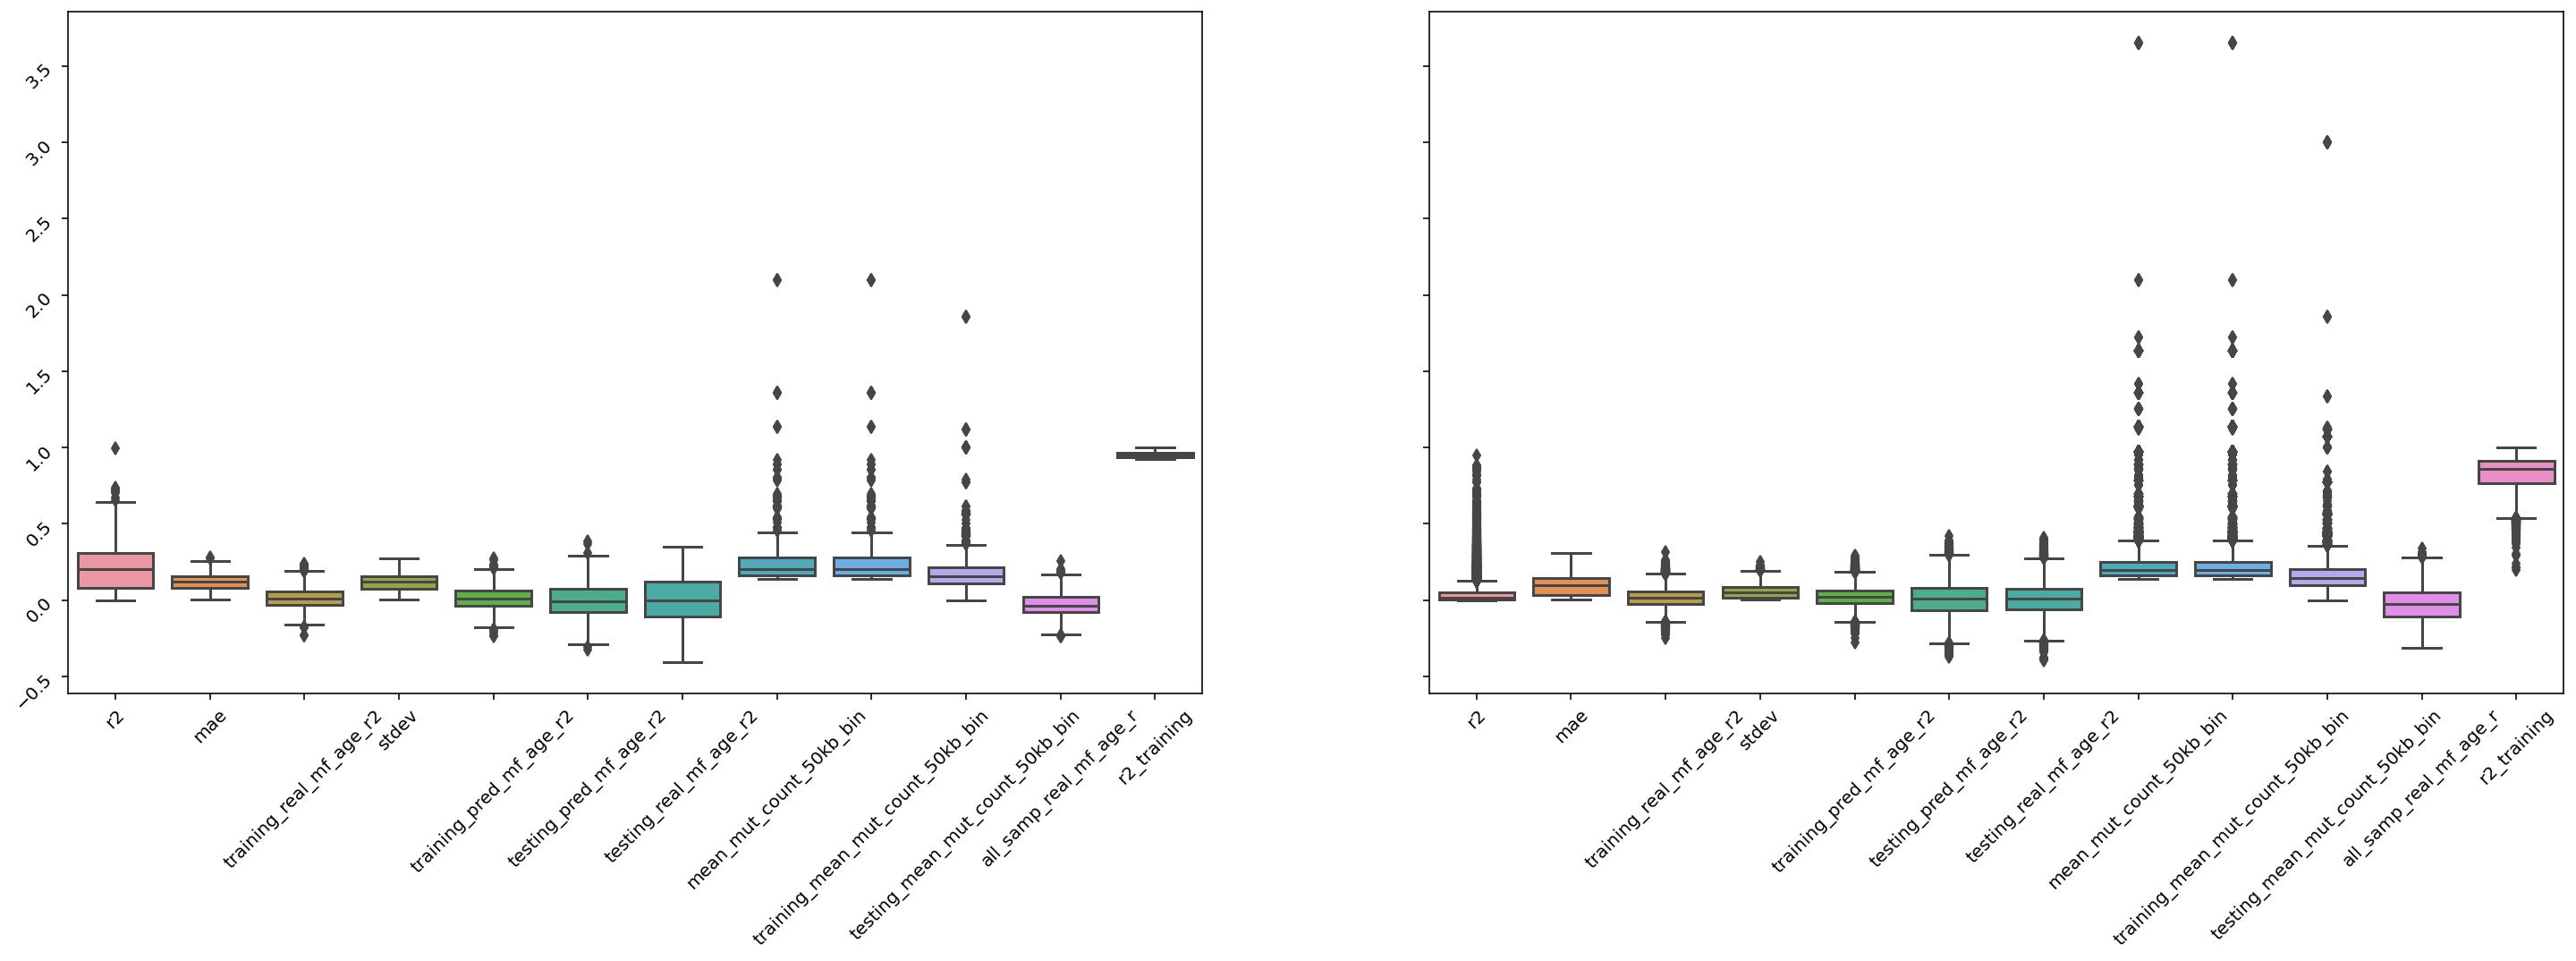

In [317]:
to_plot = mut_clock.performance_df.loc[feature_names_of_nonzero]
fig, axes = plt.subplots(1,2, figsize=(25, 7), sharey = True)
# plot a boxplot for each column
sns.boxplot(data=to_plot, ax = axes[0])
# rotate the xtick labels of axes[0], right justified
axes[0].tick_params(labelrotation=45)


sns.boxplot(data = mut_clock.performance_df.loc[set(mut_clock.performance_df.index) - set(feature_names_of_nonzero)], ax = axes[1])
axes[1].tick_params(labelrotation=45)


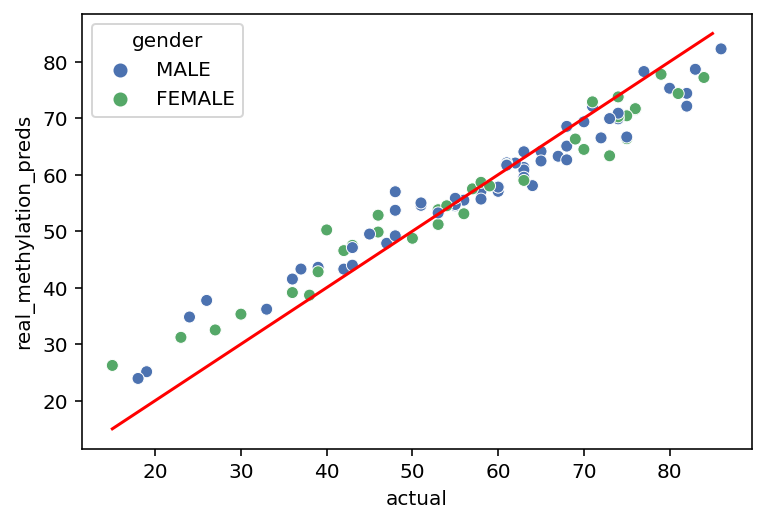

In [335]:
pred_by_cpg_num2_df['real_methylation_preds'] = model.predict(X_test_real_methyl[best_predicted_cpgs])
sns.scatterplot(x = 'actual', y = 'real_methylation_preds', hue = 'gender', data = pred_by_cpg_num2_df)
# y = x line
plt.plot([15, 85], [15, 85], color = 'red')

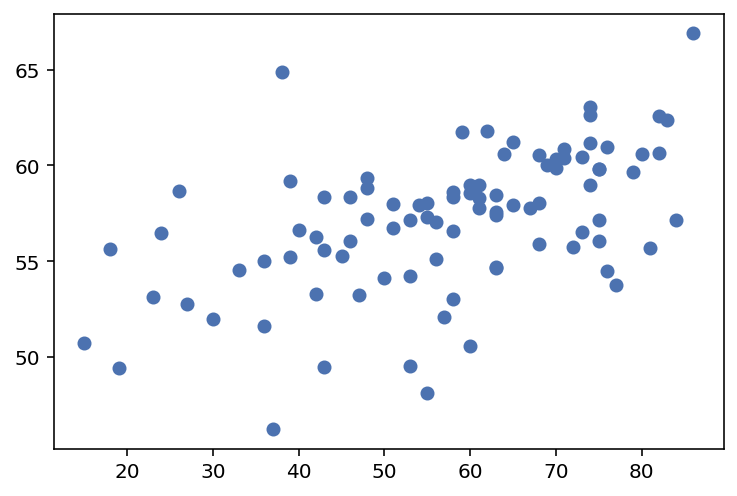

In [337]:
# linreg
lr = LinearRegression()
lr.fit(X_test_real_methyl, y_test)
preds = lr.predict(X_test_pred_methyl)
plt.scatter(y_test, preds)

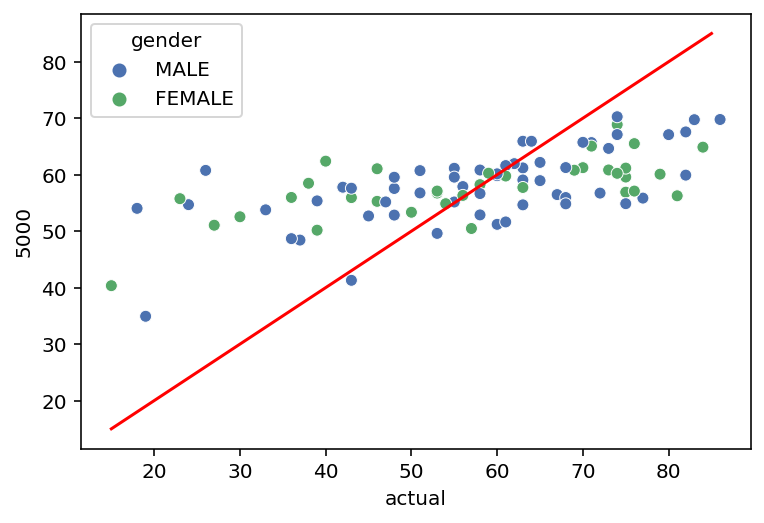

In [294]:
pred_by_cpg_num2_df['gender'] = all_methyl_age_df_t.loc[pred_by_cpg_num2_df.index, 'gender']
sns.scatterplot(x = 'actual', y = 5000, hue = 'gender', data = pred_by_cpg_num2_df)
# y = x line
plt.plot([15, 85], [15, 85], color = 'red')

array([[1.      , 0.170692],
       [0.170692, 1.      ]])

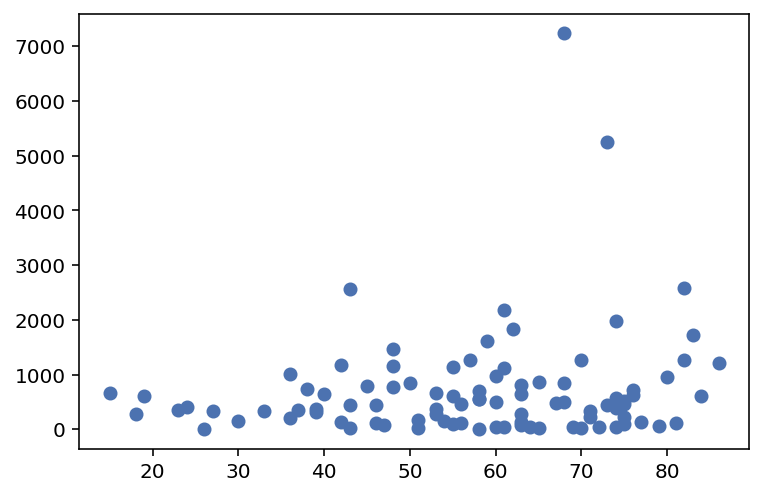

In [295]:
# show that this beats mutation burden
mut_burden = all_mut_w_age_df['case_submitter_id'].value_counts()
plt.scatter(pred_by_cpg_num2_df['actual'], mut_burden.loc[pred_by_cpg_num2_df.index])
np.corrcoef(pred_by_cpg_num2_df['actual'], mut_burden.loc[pred_by_cpg_num2_df.index])

In [259]:
pred_methyl_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022823_output/TCGA_*/methyl_predictions_*Truescramble.parquet")
pred_perf_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022823_output/TCGA_*/prediction_performance_*Truescramble.parquet")

mut_clock_scramble = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = pred_methyl_fns,
            predicted_perf_fns = pred_perf_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output",
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = ''
            )

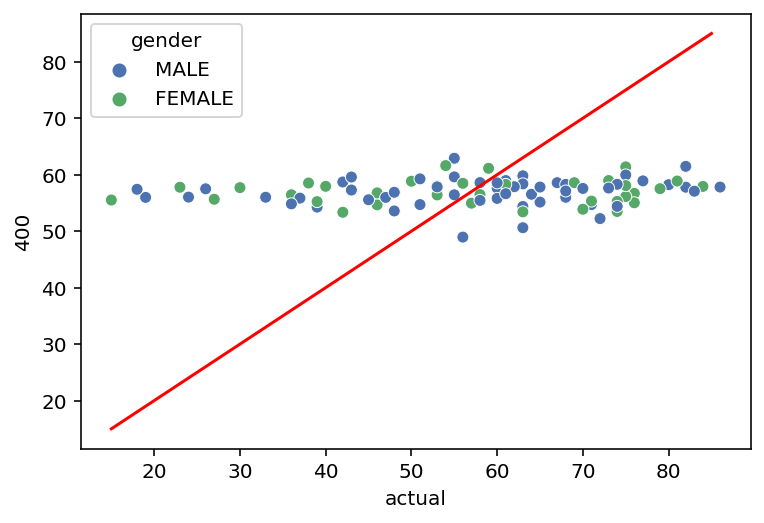

In [273]:
pred_by_cpg_num_scrambled_df['gender'] = all_methyl_age_df_t.loc[pred_by_cpg_num_scrambled_df.index, 'gender']
sns.scatterplot(x = 'actual', y = 400, hue= 'gender', data = pred_by_cpg_num_scrambled_df)
# y = x line
plt.plot([15, 85], [15, 85], color = 'red')

In [323]:
pred_methyl_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_*/methyl_predictions_elasticNet*Falsescramble.parquet")
pred_perf_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output/TCGA_*/prediction_performance_elasticNet*Falsescramble.parquet")

mut_clock_bigger_old = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = pred_methyl_fns,
            predicted_perf_fns = pred_perf_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output",
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = ''
            )

In [324]:
mut_clock_bigger_old.performance_df['r2_training'] = mut_clock_bigger_old.predicted_methyl_df.loc[mut_feat.train_samples].corrwith(all_methyl_age_df_t.loc[mut_feat.train_samples, mut_clock_bigger_old.predicted_methyl_df.columns ])

In [339]:
mut_clock.performance_df.corr()

,r2,mae,training_real_mf_age_r2,stdev,training_pred_mf_age_r2,testing_pred_mf_age_r2,testing_real_mf_age_r2,mean_mut_count_50kb_bin,training_mean_mut_count_50kb_bin,testing_mean_mut_count_50kb_bin,all_samp_real_mf_age_r,r2_training
r2,1.000000,0.128160,-0.003874,0.493493,-0.014684,-0.082856,-0.094542,0.018961,0.018961,0.061798,-0.102055,0.263035
mae,0.128160,1.000000,0.143713,0.820221,0.159358,0.051873,-0.031079,0.135737,0.135737,0.156995,-0.382223,-0.398113
training_real_mf_age_r2,-0.003874,0.143713,1.000000,0.086013,0.910066,0.172726,0.063833,0.039829,0.039829,0.015865,0.091976,-0.097987
stdev,0.493493,0.820221,0.086013,1.000000,0.098866,0.056580,-0.053060,0.107676,0.107676,0.154069,-0.325606,-0.028145
training_pred_mf_age_r2,-0.014684,0.159358,0.910066,0.098866,1.000000,0.192835,0.036288,0.010306,0.010306,-0.007390,0.061130,-0.120269
testing_pred_mf_age_r2,-0.082856,0.051873,0.172726,0.056580,0.192835,1.000000,0.181480,0.084201,0.084201,0.062666,0.066697,0.044077
testing_real_mf_age_r2,-0.094542,-0.031079,0.063833,-0.053060,0.036288,0.181480,1.000000,0.098326,0.098326,0.055405,0.099570,0.075955
mean_mut_count_50kb_bin,0.018961,0.135737,0.039829,0.107676,0.010306,0.084201,0.098326,1.000000,1.000000,0.867687,0.031043,0.031957
training_mean_mut_count_50kb_bin,0.018961,0.135737,0.039829,0.107676,0.010306,0.084201,0.098326,1.000000,1.000000,0.867687,0.031043,0.031957
testing_mean_mut_count_50kb_bin,0.061798,0.156995,0.015865,0.154069,-0.007390,0.062666,0.055405,0.867687,0.867687,1.000000,-0.009665,0.044237


In [326]:
mut_clock_bigger_old.performance_df.corr()

,r2,mae,training_real_mf_age_r,r2_training
r2,1.000000,0.146501,0.158091,0.362241
mae,0.146501,1.000000,0.237913,-0.019278
training_real_mf_age_r,0.158091,0.237913,1.000000,0.084614
r2_training,0.362241,-0.019278,0.084614,1.000000


In [330]:
pred_by_cpg_num_bigger_old = {}
for best_num in [100, 1000, 5000, 10000, 25000, 50000]:
    best_predicted_cpgs = mut_clock_bigger_old.performance_df['r2_training'].nlargest(best_num).index
    model = mut_clock_bigger_old.train_epi_clock(X = mut_clock_bigger_old.all_methyl_age_df_t.loc[mut_feat.test_samples, best_predicted_cpgs], y = mut_clock_bigger_old.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index'])
    preds = model.predict(mut_clock_bigger_old.predicted_methyl_df.loc[mut_feat.test_samples, best_predicted_cpgs])
    pred_by_cpg_num_bigger_old[best_num] = preds
pred_by_cpg_num_bigger_old['actual'] = mut_clock_bigger_old.all_methyl_age_df_t.loc[mut_feat.test_samples, 'age_at_index']
pred_by_cpg_num_bigger_old_df = pd.DataFrame(pred_by_cpg_num_bigger_old)
pred_by_cpg_num_bigger_old_df.corr()

,100,1000,5000,10000,25000,50000,actual
100,1.000000,-0.017482,-0.008751,-0.016533,0.034771,0.063844,0.171814
1000,-0.017482,1.000000,0.499010,0.548284,0.189960,0.089271,0.048430
5000,-0.008751,0.499010,1.000000,0.573894,0.350704,0.318382,0.124569
10000,-0.016533,0.548284,0.573894,1.000000,0.646727,0.436634,0.233655
25000,0.034771,0.189960,0.350704,0.646727,1.000000,0.910555,0.256957
50000,0.063844,0.089271,0.318382,0.436634,0.910555,1.000000,0.292596
actual,0.171814,0.048430,0.124569,0.233655,0.256957,0.292596,1.000000


#### results of small test

In [344]:
glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_0meqtl*/methyl_predictions_xgboost*Falsescramble.parquet")

['/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_0startTopCpGs_25000maxDBsites_0crossValNum/methyl_predictions_xgboost_Falsescramble.parquet',
 '/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_10startTopCpGs_25000maxDBsites_0crossValNum/methyl_predictions_xgboost_Falsescramble.parquet']

In [362]:
mut_clock_small_no_matrix = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_0meqtl*/methyl_predictions_xgboost*Falsescramble.parquet"),
            predicted_perf_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_0meqtl*/prediction_performance_xgboost*Falsescramble.parquet"),
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output",
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = ''
            )
methyl_pred_no_matrix = methylation_pred.methylationPrediction(
            mut_feat_store_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_0meqtl*/*features.pkl"),
            model_type = 'xgboost',
            scramble = False
            #trained_models_fns = [trained_models_fn]
            )

mut_clock_small_yes_matrix = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_1000meqtl*/methyl_predictions_xgboost*Falsescramble.parquet"),
            predicted_perf_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_1000meqtl*/prediction_performance_xgboost*Falsescramble.parquet"),
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/022323_output",
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = ''
            )

methyl_pred_yes_matrix = methylation_pred.methylationPrediction(
            mut_feat_store_fns = glob.glob("/cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_*_1000meqtl*/*features.pkl"),
            model_type = 'xgboost',
            scramble = False
            #trained_models_fns = [trained_models_fn]
            )



Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_0startTopCpGs_25000maxDBsites_0crossValNum/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_0startTopCpGs_25000maxDBsites_0crossValNum.features.pkl
Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_10startTopCpGs_25000maxDBsites_0crossValNum/TCGA_SKCM_500correl_500correlExt_0meqtl_50000nearby_Bothagg_10numCpGs_10startTopCpGs_25000maxDBsites_0crossValNum.features.pkl
Done reading /cellar/users/zkoch/methylation_and_mutation/output_dirs/030123_output/TCGA_SKCM_500correl_500correlExt_1000meqtl_50000nearby_Bothagg_10numCpGs_0startTopCpGs_25000maxDBsites_0crossValNum/TCGA_SKCM_500correl_500correlExt_1000meqtl_50000nearby_Bothagg_10numCpGs_0startTopCpGs_25000maxDBsites_0crossValNum.features.pkl
Done reading /cellar/us

In [364]:
methyl_pred_no_matrix.mut_feat_store['feat_mats']['cg02391549'].sum().tail(15)

pos_corr                    1.09
neg_corr                    0.46
pos_corr_ext              190.35
neg_corr_ext               44.79
nearby                    319.43
matrixqtl_neg_beta          0.00
matrixqtl_pos_beta          0.00
matrixqtl_neg_beta_ext      0.00
matrixqtl_pos_beta_ext      0.00
db_neg_beta                 0.00
db_pos_beta                 0.00
db_neg_beta_ext             0.00
db_pos_beta_ext             6.57
gender_FEMALE             175.00
gender_MALE               287.00
dtype: float64

In [365]:
methyl_pred_yes_matrix.mut_feat_store['feat_mats']['cg02391549'].sum().tail(15)

pos_corr                    1.09
neg_corr                    0.46
pos_corr_ext              190.35
neg_corr_ext               44.79
nearby                    319.43
matrixqtl_neg_beta        321.08
matrixqtl_pos_beta          0.00
matrixqtl_neg_beta_ext    516.04
matrixqtl_pos_beta_ext      0.00
db_neg_beta                 0.00
db_pos_beta                 0.00
db_neg_beta_ext             0.00
db_pos_beta_ext             6.57
gender_FEMALE             175.00
gender_MALE               287.00
dtype: float64

In [ ]:
mut_clock_small_yes_matrix.feat_mat

<AxesSubplot:>

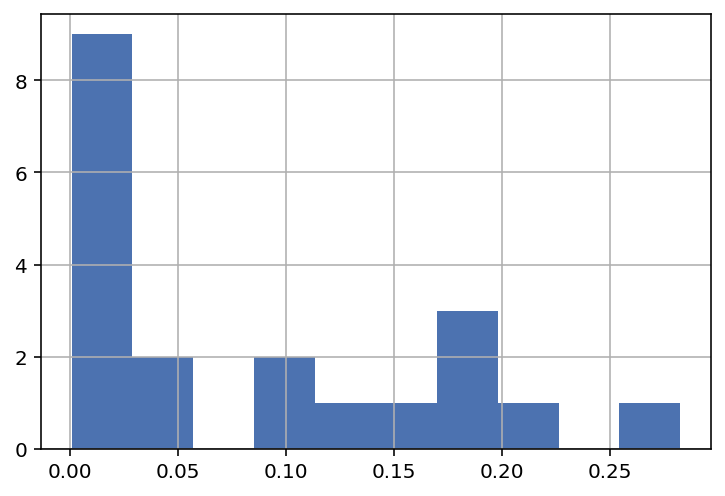

In [366]:
mut_clock_small_yes_matrix.performance_df['r2'].hist()

<AxesSubplot:>

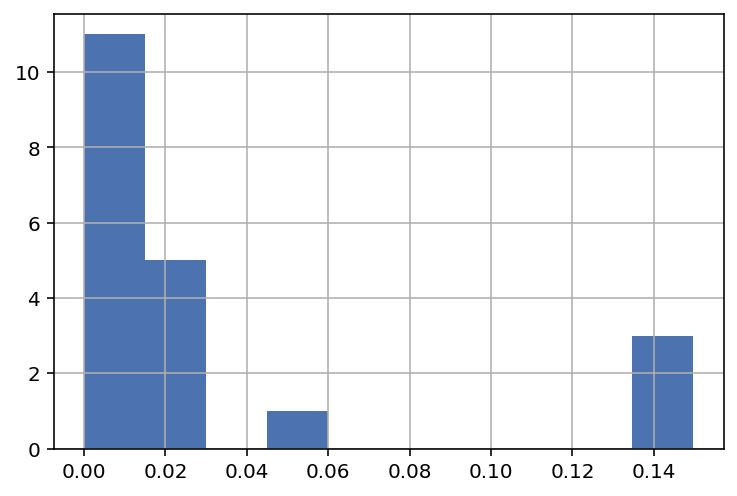

In [367]:
mut_clock_small_no_matrix.performance_df['r2'].hist()

# ICGC testing

In [230]:
icgc_mut_feat = mutation_features.mutationFeatures(
    all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = out_dir, dataset = 'PRAD-CA',
    consortium = 'ICGC', train_samples = train, test_samples = test,
    matrix_qtl_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/icgc_muts_011423"
    )

In [289]:
icgc_cpg_pred_priority = icgc_mut_feat.choose_cpgs_to_train(mi_df = icgc_mi_df, bin_size=20000, sort_by=['mutual_info', 'count'])
icgc_mut_feat.create_all_feat_mats(
    cpg_ids = icgc_cpg_pred_priority.head(10)['#id'].to_list(), aggregate='Both',
    num_correl_sites=5000, num_correl_ext_sites=100, max_meqtl_sites=100,
    nearby_window_size=25000
    )

Finished 0 of 10


In [ ]:
mut_feat_store_fns = glob.glob('/cellar/users/zkoch/methylation_and_mutation/output_dirs/020723_output/ICGC__5000correl_100correlExt_100meqtl_25000nearby_Bothagg_2500numCpGs_*/*features.pkl')
# train predictors for these cpgs
icgc_methyl_pred = methylation_pred.methylationPrediction(
    mut_feat_store_fns = mut_feat_store_fns,
    model_type = 'xgboost'
    )
icgc_methyl_pred.train_all_models()
icgc_methyl_pred.apply_all_models()
icgc_methyl_pred.save_models_and_preds()

In [102]:
train_df = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, icgc_methyl_pred.mut_feat_store['cpg_ids']]
train_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.train_samples, 'age_at_index'].dropna()
train_df = train_df.loc[train_ages.index, :]

test_df = icgc_methyl_pred.pred_df
test_ages = icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'age_at_index']
model = ElasticNetCV(cv=5, random_state=0, max_iter=10000, n_jobs=-1, verbose=1)
# train the model on the training set
model.fit(train_df, train_ages)
# predict the ages on the test set
pred_ages = model.predict(test_df)

0.8288474017235258

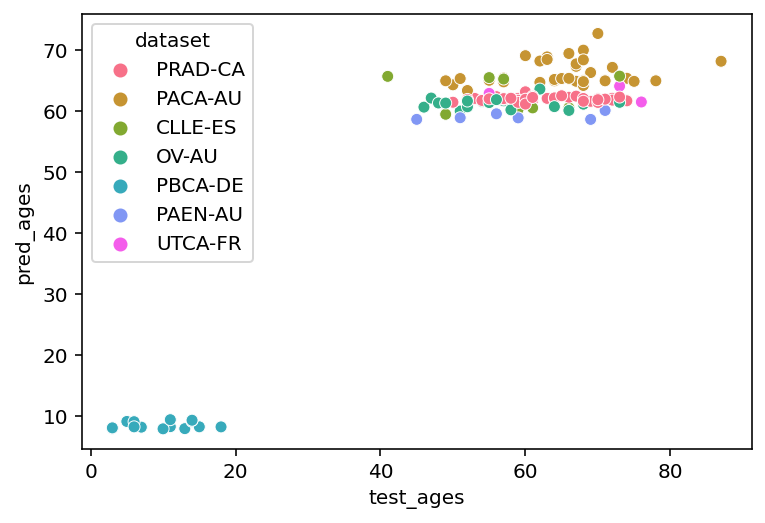

In [113]:
to_plot = pd.DataFrame({'pred_ages':pred_ages, 'test_ages':test_ages, 'dataset': icgc_methyl_age_df_t.loc[icgc_methyl_pred.test_samples, 'dataset'].to_list()})
sns.scatterplot(data=to_plot, x='test_ages', y='pred_ages', hue='dataset')
print(np.corrcoef(test_ages, pred_ages)[0][1]**2

# Comethylation

In [134]:
mut_scan = compute_comethylation.mutationScan(
    all_mut_w_age_df, illumina_cpg_locs_df, 
    all_methyl_age_df_t, corr_dir = corr_dir,
    age_bin_size = 5, max_dist = 2500,
    num_correl_sites = 100, num_background_events = 10,
    matched_sample_num = 50
    )

In [170]:
# TODO change 10k back to 100k and move subsetting of muts back to previous loc
comparison_sites_df_test, all_metrics_df_test = mut_scan.look_for_disturbances(
    start_num_mut_to_process = 0,
    end_num_mut_to_process = 10,
    linkage_method='dist', 
    out_dir = out_dir, 
    corr_direction = 'pos'
    )

Finding nearby measured cpgs ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

comparison sites df shape (1010, 24)
Wrote comparison sites df to /cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/comparison_sites_0-10Muts_100corrSites_pos_qnorm3SD_100background


Calculating effect of mutation on comparison sites: 100%|██████████| 1010/1010 [11:50<00:00,  1.42it/s]


Done getting effect of mutation on each site
got all metrics
writing results to /cellar/users/zkoch/methylation_and_mutation/output_dirs/022023_output/all_metrics_0-10Muts_100corrSites_pos_qnorm3SD_100background


In [185]:
all_mut_w_age_df.loc[all_mut_w_age_df['mut_event'] == 'TCGA-D9-A6EC_9:138891235']

,case_submitter_id,chr,start,end,reference,alt,DNA_VAF,mutation,dataset,gender,age_at_index,dataset_r,gender_r,mut_cpg,mut_event


<AxesSubplot:>

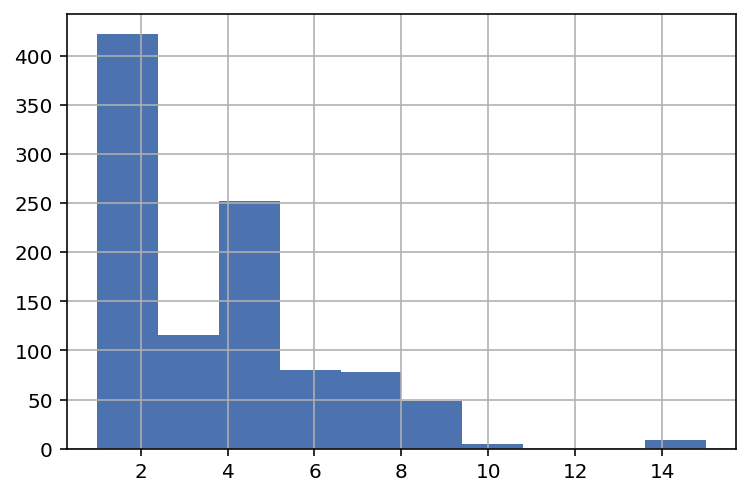

In [186]:
comparison_sites_df_test['comp_site_len'] = comparison_sites_df_test['comparison_sites'].apply(lambda x: len(x))

<AxesSubplot:>

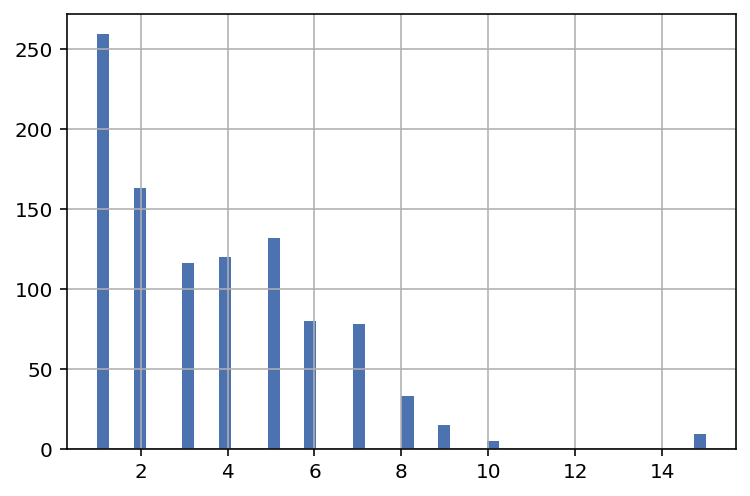

In [190]:
comparison_sites_df_test['comp_site_len'].hist(bins=50)